## Étude stochastique pour délimiter une aire d'alimentation

L'étude stochastique pour une aire d'alimentation consiste à définir un cadre d'étude où nous connaissons une partie ou aucune des valeurs de chaque paramètre géologique et hydrogéologique. Pour cela, le calcul du de l'efficacité est faite pour les méthodes prédéfinis et l'utilisation de données conditionnantes est possible. Dans tous les cas, le cadre hétérogène est choisi pour les calculs (matrice à valeurs aléatoires obtenue par une simulation séquentielle gausienne (SGS)). De plus, l'utilisation de la méthode du seuil permettra de gagner en confiance sur les zones Zu moyennes calculées.

Pour faire fonctionner l'étude stochastique, il faut pouvoir utiliser la classe ZuPer au complet puis de choisir la méthode stochastic_study. Le test se fait alors sur un cadre hétérogène pour chaque méthode de délimitation avec 10 données conditionnantes et 10 simulations. Puis un deuxième exemple avec 30 données conditionnantes, mais avec 30 simulations.

In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import ifm as ifm
import geone as gn
import pandas as pds
import scipy as sp
import geopandas as gpd

from scipy.stats import gmean
from tqdm import tqdm
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from shapely.geometry import Polygon
from scipy.optimize import minimize

class zuper:
    
    doc = ''

    nnodes, nelements, nbx_nd, nby_nd, nbx_el, nby_el = 0, 0, 0, 0, 0, 0
    x, y, x_el, y_el, ox, oy, dx, dy = 0, 0, 0, 0, 0, 0, 0, 0
    xw, yw, qw, id_w, pos_w = 0, 0, 0, 0, 0
    xmin, xmax, ymin, ymax = 0, 0, 0, 0

    cov = 0
    el, alpha, title = [('spherical', {'w':0.25, 'r':[1300, 1300]})], 0, 'title'

    k_matrix, r_matrix, k_matrix_el, r_matrix_el, k_mean, r_mean = 0, 0, 0, 0, 0, 0
    b, f = 0, 0
    mu_k, std_k, mu_r, std_r = 1.8, 0.35, 400, 15

    pos_cond = 0
    v1, v2 = 0,0
    PI_LIM = 0
    tau, a_zu, n = 0, 0, 0

    dict_params, dict_results = {}, {}
    
    def __init__(self, url):
        self.doc = ifm.loadDocument(url)
        self.nnodes = self.doc.getNumberOfNodes()
        self.nelements = self.doc.getNumberOfElements()
        self.x, self.y = np.zeros((self.nnodes,)), np.zeros((self.nnodes,))
        for i in range(self.nnodes):
            self.x[i] = self.doc.getX(i)
            self.y[i] = self.doc.getY(i)
    
        self.xmin, self.xmax, self.ymin, self.ymax = np.min(self.x), np.max(self.x), np.min(self.y), np.max(self.y)
        self.dx = self.x[1] - self.x[0]
        self.nbx_el = int(np.round( (self.xmax - self.xmin)/self.dx ))
        self.dy = self.y[0] - self.y[self.nbx_el + 1]
        self.nby_el = int(np.round( (self.ymax - self.ymin)/self.dy ))
        self.s = self.dx*self.dy
        self.nbx_nd, self.nby_nd = self.nbx_el + 1, self.nby_el + 1
        self.ox, self.oy = self.doc.getOriginX(), self.doc.getOriginY()
        self.qw = float( str( self.doc.createWellManager().getWells()[0].getPropertyValue(8) ).split('[')[0] )
        self.xw = int(float(str(self.doc.createWellManager().getWells()[0].getPropertyValue(3)).split(' ')[0]))
        self.yw = int(float(str(self.doc.createWellManager().getWells()[0].getPropertyValue(4)).split(' ')[0]))
        
        for i in range(self.nnodes):
            if int( self.x[i] ) == self.xw and int( self.y[i] ) == self.yw:
                self.id_well = i

        self.x.shape = (self.nby_nd, self.nbx_nd)
        self.y.shape = (self.nby_nd, self.nbx_nd)
        self.x_el = self.x[:self.nby_el, :self.nbx_el]
        self.y_el = self.y[:self.nby_el, :self.nbx_el]

        for i in range(self.nby_nd):
            for j in range(self.nbx_nd):
                if int( self.x[i][j] ) == self.xw and int( self.y[i][j] ) == self.yw:
                    self.pos_well = [j,i]

        self.cov = gn.covModel.CovModel2D(self.el, self.alpha, self.title)
        print("created object")

    def get_params(self):
        self.k_matrix = self.simulation_sgs(self.nbx_nd, self.nby_nd, np.array([[61, 244]]), [2.5], self.mu_k, self.std_k, seed=8948474) # change conditions with well values for references
        self.k_matrix_el = self.k_matrix[:self.nby_el, :self.nbx_el]
        self.k_mean = gmean(self.k_matrix, axis=None)
        
        self.r_matrix = self.simulation_sgs(self.nbx_nd, self.nby_nd, np.array([[61, 244]]), [401.5], self.mu_r, self.std_r, seed=7528660) # change conditions with well values for references
        self.r_matrix_el = self.r_matrix[:self.nby_el, :self.nbx_el]
        self.r_mean = np.mean(self.r_matrix, axis=None)/365/1000

        self.b = self.doc.getParamValue(108, 0) - self.doc.getParamValue(106, 0)
        self.f = self.doc.getParamValue(201, 0)

    def simulation_sgs(self, nx, ny, x, v, mu, std, seed=None):
        if x is None:
            return gn.geosclassicinterface.simulate2D(self.cov, (nx, ny), (self.dx, self.dy), (self.ox, self.oy), x = x*np.array([self.dx, self.dy]), v = v, mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]
            
        return gn.geosclassicinterface.simulate2D(self.cov, (nx, ny), (self.dx, self.dy), (self.ox, self.oy), x = x*np.array([self.dx,self.dy]), v = v, mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]

    def set_parameters_and_simulation(self, list_id_parms, list_val_parms):
        for j in range(len(list_id_parms)):
            for i in range(self.nelements):
                self.doc.setParamValue(list_id_parms[j], i, list_val_parms[j][i])

        self.doc.startSimulator()
        self.doc.stopSimulator()

    def set_variation_homogeneity(self, conditional=False, perm_sim=False, rech_sim=False):
        if conditional==True:
            self.dict_params['conductivity'] = self.simulation_sgs(self.nbx_nd, self.nby_nd, self.pos_cond, self.v1, self.mu_k, self.std_k, seed=None)
            self.dict_params['recharge'] = self.simulation_sgs(self.nbx_nd, self.nby_nd, self.pos_cond, self.v2, self.mu_r, self.std_r, seed=None)/365/1000
            
        else:
            if perm_sim==True:
                self.dict_params['conductivity'] = self.k_matrix
            else:
                self.dict_params['conductivity'] = np.ones((self.nby_nd, self.nbx_nd))*self.k_mean
                
            if rech_sim==True:
                self.dict_params['recharge'] = self.r_matrix/365/1000
            else:
                self.dict_params['recharge'] = np.ones((self.nby_nd, self.nbx_nd))*self.r_mean

        k_el = self.dict_params['conductivity'][:self.nby_el, :self.nbx_el]
        r_el = self.dict_params['recharge'][:self.nby_el, :self.nbx_el]

        self.set_parameters_and_simulation([100, 113], [10**k_el.flatten(),  r_el.flatten()])

    def get_pos_and_data_for_condi_test(self, N, value_param_well):
        mesh_x = np.random.choice(122, N)
        mesh_y = np.random.choice(286, N)
        self.v1, self.v2 = np.zeros((N,)), np.zeros((N,))
        self.pos_cond = np.zeros((N,2)) 
        
        for i in range(N):
            self.pos_cond[i] = mesh_x[i], mesh_y[i]
            self.v1[i] = self.k_matrix_el[ mesh_y[i] ][ mesh_x[i] ]
            self.v2[i] = self.r_matrix_el[ mesh_y[i] ][ mesh_x[i] ]

        test_bis = np.unique(self.pos_cond, axis=0, return_index=True)

        self.pos_cond = test_bis[0].copy()

        self.v1 = [self.v1[test_bis[1][i]] for i in range(len(self.pos_cond))]
        self.v2 = [self.v2[test_bis[1][i]] for i in range(len(self.pos_cond))]

        self.pos_cond = np.vstack((self.pos_cond, self.pos_well))
        self.v1.append(value_param_well[0])
        self.v2.append(value_param_well[1])

    def get_results(self, name_res=['hydraulic charge', 'age', 'exit-time', 'probabilities']):
        var = 1
        for name in name_res:
            if name=='hydraulic charge':
                self.dict_results[name] = np.array([ self.doc.getResultsFlowHeadValue(i) for i in range(self.nnodes) ])
                self.dict_results[name].shape = (self.nby_nd, self.nbx_nd)

            elif name in ['age', 'exit-time', 'probabilities']:
                self.doc.setMultiSpeciesId(var)
                self.dict_results[name] = np.array([ self.doc.getResultsTransportMassValue(i) for i in range(self.nnodes) ])
                self.dict_results[name][ self.dict_results[name]<0 ] = 0
                self.dict_results[name].shape = (self.nby_nd, self.nbx_nd)
                var+=1

        self.dict_results['contributions'] = self.dict_results['probabilities'] * self.dict_params['recharge'] * self.s

    def standard_method(self, PI):
        c = self.dict_results['contributions'].flatten()
        index = np.argsort(c)[::-1]
        z = np.zeros((self.nnodes,))
        res = 0
        self.PI_LIM = PI*self.qw
        self.tau=0
        
        for i in index:
            res+=c[i]
            z[i] = 1
            self.tau+=1
            if res>=self.PI_LIM:
                break;
        
        z.shape = (self.nby_nd, self.nbx_nd)
        self.dict_results['zu'] = z

    def meanlife_method(self, PI):
        p, e, c = self.dict_results['probabilities'].flatten(), self.dict_results['exit-time'].flatten(), self.dict_results['contributions'].flatten()
        z = np.zeros((self.nnodes,))
        ind_e = np.argsort(e)
        res = 0
        self.PI_LIM = PI * self.qw
        res+=c[self.id_well]
        z[self.id_well] = 1
        self.tau=1

        for i in ind_e:
            if e[i]!=0 and p[i]>0.01:
                res+=c[i]
                z[i] = 1
                self.tau+=1
                if res>=self.PI_LIM:
                    break;

        z.shape = (self.nby_nd, self.nbx_nd)
        self.dict_results['zu'] = z

    def cfr_method(self, PI):
        r = np.sqrt( (self.qw*PI) / (np.pi*self.r_mean) )
        d = np.sqrt((self.x - self.xw)**2 + (self.y - self.yw)**2) < r
        self.tau = np.unique(d, return_counts=True)[1][1]
        d = d.astype(float)
        d.resize(self.nby_nd, self.nbx_nd)
        self.dict_results['zu'] = d

    def lerner_method(self, PI):
        R = self.r_mean
        b = self.b
        T = self.k_mean
        poro = self.f
        Q = PI*self.qw 
        xw, yw = self.xw, self.yw
        xmin, xmax = self.xmin, self.xmax
        ymin, ymax = self.ymin, self.ymax
        a = (ymax - ymin) 
        nx = self.nbx_nd
        ny = self.nby_nd
        
        # define axis vector in the mesh
        xv = np.linspace(xmin,xmax,nx)
        yv = np.linspace(ymin,ymax,ny)
        xx, yy = np.meshgrid(xv, yv)
        
        # define the parameter for the size of calculation
        xl = ymax - yy
        yl = xx 
        xlw = ymax - yw
        ylw = xw
        
        # define the initial velocity in x-axis and y-axis for calculation
        vxlr = R * xl / (b * poro)
        vylr = 0
        
        # define the limit of y
        ym = np.pi * (yl - ylw) / (2 * a)
        
        # function of calculation of velocity in x-axis
        def Ux(xp):
            xm = np.pi * (xl - xp) / (2 * a)
            xp = np.pi * (xl + xp) / (2 * a)
        
            return - Q / (8 * a * b * poro) * ( np.sin(xm) / (np.cosh(ym) - np.cos(xm)) +
                                        np.sin(xp) / (np.cosh(ym) + np.cos(xp)))
        
        # function of calculation of velocity in x-axis
        def Uy(xp):
            xm = np.pi * (xl - xp) / (2 * a)
            xp = np.pi * (xl + xp) / (2 * a)
        
            return   - Q * np.sinh(ym) / (8 * a * b * poro) * ( 1 / (np.cosh(ym) - np.cos(xm)) +
                                                    1 / (np.cosh(ym) + np.cos(xp))) 
        
        # use of well image to calculate velocity from the well
        vxlw = Ux(xlw) + Ux(-xlw)
        vylw = Uy(xlw) + Uy(-xlw)
        
        vxl = vxlr + vxlw
        vyl = vylr + vylw
        
        vx = vyl
        vy = - vxl
        
        # function use to define the equation needed to be resolve
        def f(x):
            xm = np.pi * (x - xlw) / ( a)
            xp = np.pi * (x + xlw) / ( a)
            return R * x / (b * poro) - Q / (2 * a * b * poro) * (1 / np.sin(xm) - 1 / np.sin(xp))
        
        # parameter of differential used in the resolution of the differential equation
        eps = 0.1
        res = root_scalar(f, bracket=[xlw + eps, a])
        xls = res.root
        xs = xw
        ys = ymax - xls

        # function to determine the velocity field
        def vxy(t, pos):
            # calculate initial variables (position, mesh) 
            x, y = pos
            xl = ymax - y
            yl = x
            xlw = ymax - yw
            ylw = xw
            ym = np.pi * (yl - ylw) / (2 * a)

           # return the velocity field for the x-axis (Ux) and y-axis (Uy)
            def Ux(xk):
                xm = np.pi * (xl - xk) / (2 * a)
                xp = np.pi * (xl + xk) / (2 * a)
                return - Q / (8 * a * b * poro) * ( np.sin(xm) / (np.cosh(ym) - np.cos(xm)) +
                                        np.sin(xp) / (np.cosh(ym) + np.cos(xp)))
        
            def Uy(xk):
                xm = np.pi * (xl - xk) / (2 * a)
                xp = np.pi * (xl + xk) / (2 * a)
                return - Q * np.sinh(ym) / (8 * a * b * poro) * ( 1 / (np.cosh(ym) - np.cos(xm)) +
                                                    1 / (np.cosh(ym) + np.cos(xp))) 

            # use image well theory to determine the true velocity field
            vx = Uy(xlw) + Uy(-xlw)
            vy = - Ux(xlw) - Ux(-xlw)  - R * xl / (b * poro)

            # return the results
            return [-vx, -vy]
        
        # resolve the differential equation with Newton-Ralphson method
        sol = solve_ivp(vxy, [0, 1e6], [xs + 30*eps, ys], max_step = 50)
        
        # get values of resolution
        ybound = sol.y[1] 
        xrightbound = sol.y[0]
        xleftbound = 2 * xw - xrightbound
        
        # define a mesh and interpolate the function for discretisation method
        cx = np.linspace(xmin, xmax, nx)
        cy = np.linspace(ymin, ymax, ny)
        dx = (xmax-xmin)/nx
        xx, yy = np.meshgrid(cx, cy)
        capture = np.zeros(yy.shape)
        f = interpolate.interp1d(ybound, xleftbound)
        
        # For loop to integrate the Lerner solution with a discretisation
        # method from the bottom to the top of model
        for M in range(ny):
            xcurent = yy[M,0]
            if xcurent < ybound[0]:
                continue
            elif xcurent > ybound[-1]:
                continue
            else:
                ytop = f(xcurent)
                jtop = int( (ytop-xmin)/dx)
                jbot = -jtop
                capture[M, jtop:jbot] = 1
            
        # keep Zu zone in "dict_results" and determine coefficients (efficiency and surface)
        self.tau = np.unique(capture, return_counts=True)[1][1]
        self.dict_results['zu'] = capture[::-1].copy()
        self.dict_results['zu'].shape = (self.nby_nd, self.nbx_nd)

    def bear_jacobs_method(self, PI):
        def x_bear_jacob(y,t,k_ord):
            a=np.cos(y)
            b=np.sin(y)/y
            c=np.exp(-t)
            
            x=-a/b - sp.special.lambertw(-c/(b*np.exp(a/b)),k=k_ord) 

            if x.imag==0:
                return x.real
            else:
                return 9999
        
        def bear_jacob(t,n_point=1000):
            Y_0=np.linspace(-np.pi+0.1,np.pi-0.1,n_point)
            Y_1=np.linspace(-np.pi+0.1,np.pi-0.1,n_point)
            X_0=np.zeros(n_point)
            X_1=np.zeros(n_point)
            for i in range(len(Y_0)):
                X_0[i]=x_bear_jacob(Y_0[i],t,k_ord=0)
                X_1[i]=x_bear_jacob(Y_1[i],t,k_ord=-1)
            

            X=np.concatenate((X_0,X_1[::-1]))
            Y=np.concatenate((Y_0,Y_1[::-1]))
            
            return X[X!=9999],Y[X!=9999]
        
        def changement_coordonnées(X,Y,xw,yw):
            new_x=-Y+xw
            new_y=X+yw
            
            return new_x,new_y
        
        def full_bear_jacob(t,q0,Qi,n,xw,yw,n_point=1000):
            tb=2*np.pi*q0**2*t/n/Qi
            xb,yb=bear_jacob(tb,n_point=n_point)
            x=xb*Qi/2/np.pi/q0
            y=yb*Qi/2/np.pi/q0
            
            return changement_coordonnées(x,y,xw,yw)
        
        def bear_and_jacobs_recharge(t,Q,xi,Recharge,gdf_coord):
            t=t[0]
            resx,resy=full_bear_jacob(t=t,q0=self.r_mean /86400 *self.s *self.nnodes,Qi=Q,n=self.f,xw=self.xw,yw=self.yw,n_point=1000)
            Poly_zu=Polygon(zip(resx,resy))
            try:
                Zu=gdf_coord.within(Poly_zu)
            except:
                return 0
            Rf=Recharge.flatten()

            return np.sum(Rf[Zu])
        	
        def bear_and_jacobs_opti(t,Q,xi,Recharge,gdf_coord):
            #print(bear_and_jacobs_recharge(t,Q,xi,Recharge,gdf_coord))
            return abs(bear_and_jacobs_recharge(t,Q,xi,Recharge,gdf_coord)-Q*xi)
        	
        def bear_and_jacobs_ZU(Q,xi,Recharge):
            dd = {'X':self.x.flatten().copy(), 'Y':self.y.flatten().copy()}
            
            dataf = gpd.GeoDataFrame(dd, geometry=gpd.points_from_xy(dd['X'], dd['Y']))
            
            x0=[3e6]
            opti=minimize(bear_and_jacobs_opti,x0,args=(Q,xi,Recharge,dataf), method='Nelder-Mead')
            resx,resy=full_bear_jacob(t=opti.x[0],q0=self.r_mean/86400 *self.s *self.nnodes /3000,Qi=Q*xi,n=self.f,xw=self.xw,yw=self.yw,n_point=1000)
            Poly_zu=Polygon(zip(resx,resy))
            Zu=dataf.within(Poly_zu)
                
            return Zu

        Zu = bear_and_jacobs_ZU(self.qw/86400, PI, self.dict_params['recharge']/86400)
        zzz = Zu.values
        self.tau = np.unique(zzz, return_counts=True)[1][1]
        zzz = zzz.astype(float)
        zzz.resize(287, 123)
        self.dict_results['zu'] = zzz

    def choose_method(self, method, PI):
        if method=='standard':
            self.standard_method(PI)

        elif method=='meanlife':
            self.meanlife_method(PI)

        elif method=='cfr':
            self.cfr_method(PI)

        elif method=='lerner':
            self.lerner_method(PI)

        elif method=='bear-jacobs':
            self.bear_jacobs_method(PI)

        else:
            print("not existing method")

    def plot_graphs(self, value, cmap='viridis', title='title', unity='', well=False, el_mesh=False, show=False, change=1):
        if el_mesh==True:
            pc=plt.contourf(self.x_el, self.y_el, value*change, cmap=cmap)

        else:
            pc=plt.contourf(self.x, self.y, value*change, cmap=cmap)
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.axis([self.xmin, self.xmax, self.ymin, self.ymax])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.colorbar(pc).set_label(unity)
        plt.title(title)
        if well==True:
            plt.plot(self.xw, self.yw, 'o', color='black', markersize=3)
        
        if show==True:
            plt.show()

    def subplot_graphs(self, values, title='title', change=1):
        plt.figure()
        plt.subplots(2,2,sharex=True, sharey=True)
        plt.subplots_adjust(wspace=0.5)
    
        for i in range(2):
            plt.subplot(2,2,i+1)
            pc=plt.contourf(self.x, self.y, values[i]*change, cmap='rainbow')
            plt.scatter(self.pos_cond[:,0], self.pos_cond[:,1], facecolors='none', edgecolors='black')
            plt.colorbar(pc,ticks=np.linspace(np.min(values[i]*change) , np.max(values[i]*change) , 3))
    
        mean=sum(values)/len(values)
        standard = np.sqrt( sum( (values - mean)**2 )/(len(values) - 1) )
        
        plt.subplot(2,2,3)
        pc=plt.contourf(self.x, self.y, mean*change, cmap='rainbow')
        plt.scatter(self.pos_cond[:,0], self.pos_cond[:,1], facecolors='none', edgecolors='black')
        plt.colorbar(pc,ticks=np.linspace(np.min(mean*change) , np.max(mean*change) , 3))
    
        plt.subplot(2,2,4)
        pc=plt.contourf(self.x, self.y, standard*change, cmap='viridis')
        plt.scatter(self.pos_cond[:,0], self.pos_cond[:,1], facecolors='none', edgecolors='black')
        plt.colorbar(pc,ticks=np.linspace(np.min(standard*change) , np.max(standard*change) , 3))
    
        plt.suptitle(title + " with " + str(len(values)) + " simulations")
        plt.show()

    def simulation_concentration(self, C0=0.1, plot_concentration=False):
        cr = np.ones((self.nelements,))*C0

        if plot_concentration==True:
            cr.shape = (self.nby_el, self.nbx_el)
            self.plot_graphs(cr, el_mesh=True, title='recharge cr', unity='[g/m2/d]', show=True)
            cr=cr.flatten().copy()

        self.doc.setMultiSpeciesId(0)
        self.set_parameters_and_simulation([207], [cr.copy()])

        self.dict_results['simulation_cr'] = np.array([ self.doc.getResultsTransportMassValue(i) for i in range(self.nnodes) ])
        concr_cr = round(self.dict_results['simulation_cr'][self.id_well],2)
        self.dict_results['simulation_cr'].shape = (self.nby_nd, self.nbx_nd)

        if plot_concentration==True:
            self.plot_graphs(self.dict_results['simulation_cr'], title='simulation cr', unity='[g/m2/d]', show=True)
        
        cm = self.dict_results['zu'].copy()
        cm[cm==0] = C0;
        cm[cm==1] = 0
        for i in range(2):
            cm = np.delete(cm, (-1), i)

        if plot_concentration==True:
            cm.shape = (self.nby_el, self.nbx_el)
            self.plot_graphs(cm, el_mesh=True, title='recharge cm', unity='[g/m2/d]', show=True)
            cm=cm.copy.flatten()

        self.doc.setMultiSpeciesId(0)
        self.set_parameters_and_simulation([207], [cm.flatten()])
        self.dict_results['simulation_cm'] = np.array([ self.doc.getResultsTransportMassValue(i) for i in range(self.nnodes) ])  
        concr_cm = round(self.dict_results['simulation_cm'][self.id_well],2)
        self.dict_results['simulation_cm'][ self.dict_results['simulation_cm']<0 ] = 0
        self.dict_results['simulation_cm'].shape = (self.nby_nd, self.nbx_nd)

        if plot_concentration==True:
            self.plot_graphs(self.dict_results['simulation_cm'], title='simulation cm', unity='[g/m2/d]', show=True)

        self.n = round((concr_cr - concr_cm)/concr_cr * 100,2)
        if self.n>100:
            self.n=100
            
        self.a_zu = round(self.tau * self.s/10000, 2)

    def bootstrap_intervalle_conf(self, data, niter, func):
        m = np.zeros(niter)
        for i in range(niter):
            bootstrap_echantillon = np.random.choice(data, len(data), replace=True)
            m[i] = func(bootstrap_echantillon, axis=None)

        return m[0]

    def currentLines(self):
        # initiate hydraulic head values in h
        h = self.dict_results['hydraulic charge']
        
        # initiate shape of x axis, y axis and hydraulic head values (h)
        self.x.shape = (self.nby_nd, self.nbx_nd)
        self.y.shape = (self.nby_nd, self.nbx_nd)
        h.shape = (self.nby_nd, self.nbx_nd)
        
        # define a mesh to calculate current liens
        xnew, ynew = np.linspace(self.xmin, self.xmax, self.nbx_nd), np.linspace(self.ymin, self.ymax, self.nby_nd)
        xx,yy = np.meshgrid(xnew,ynew)
        
        # calculate hydraulic gradient and velocities in x-axis and y-axis
        dhy,dhx=np.gradient(h[::-1])
        ux=-self.k_mean*dhx
        uy=-self.k_mean*dhy
        
        # initiate shape of mesh
        xx.shape = (self.nby_nd, self.nbx_nd)
        yy.shape = (self.nby_nd, self.nbx_nd)
        
        # plot the graph of current lines with hydraulic head
        pc = plt.contourf(self.x, self.y, h, cmap='Oranges')
        plt.streamplot(xx,yy,ux,uy,0.24, color='black', broken_streamlines=False)
        cbar = plt.colorbar(pc, ticks=np.linspace(np.min(h),np.max(h),5))
        cbar.set_label('[m]')
        plt.axis([self.xmin, self.xmax, self.ymin, self.ymax])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title('Currentlines and\nhydraulic conductivity\n')
        plt.show()

    def determinist_study(self, case, method):
        self.get_params()
        global tab_res, tab_zu
        for i in case:
            tab_res = []
            tab_zu = []
            for j in tqdm(range(len(method))):
                self.set_variation_homogeneity(*i)
                self.get_results()
                tab_surf, tab_eff = [], []
                tab_zu.append([])
                for k in np.arange(0.1, 1.1, 0.1):
                    self.choose_method(method[j], k)
                    self.simulation_concentration()
                    tab_surf.append(data.a_zu)
                    tab_eff.append(data.n)
                    tab_zu[j].append(self.dict_results['zu'])
    
                plt.plot(tab_surf, tab_eff, 'o-')
                tab_res.append([tab_surf, tab_eff])
    
            plt.grid()
            plt.xlabel(r'$A_{zu}$ [$hect$]')
            plt.ylabel(r'$\eta$ [%]')
            plt.title(r'Pareto Graph - $\eta$-$A_{zu}$')
            plt.legend(method, loc='upper right', bbox_to_anchor=(1.81, 1.03))
            plt.gca().invert_yaxis()
            plt.show()
            
            for i in self.dict_params.keys():
                self.plot_graphs( self.dict_params[i], title=i, show=True)
            
            for i in self.dict_results.keys():
                self.plot_graphs( self.dict_results[i], title=i, show=True )
    
    def stochastic_study(self, N, method, nb_sim):
        self.get_params()
        self.get_pos_and_data_for_condi_test(N, [2.5, 401.5])
        global tab_zu, tab_k, tab_r
        tab_zu = []
        tab_k, tab_r, tab_eff, tab_surf, tab_k_const, tab_r_const = [], [], [], [], [], []
        for i in tqdm(range(nb_sim), 'calcul des Zu'):
            self.set_variation_homogeneity(conditional=True)
            self.get_results()
            if np.sum(self.dict_results['contributions'])>=self.qw*0.9:
                tab_k.append( self.dict_params['conductivity'] )
                tab_r.append( self.dict_params['recharge'] )
                tab_zu.append([])
                for j in range(len(method)):
                    if method[j] in ['standard', 'meanlife']:
                        self.choose_method(method[j], 0.9)
                        tab_zu[-1].append( self.dict_results['zu'] )
                    else:
                        self.k_mean = self.bootstrap_intervalle_conf(self.v1, 1, np.mean)
                        self.r_mean = self.bootstrap_intervalle_conf(self.v2, 1, np.mean)/365000
                        self.set_variation_homogeneity(False, False, False)
                        self.get_results()
                        self.choose_method(method[j], 0.9)
                        tab_zu[-1].append( self.dict_results['zu'] )
                        tab_k_const.append( self.k_mean )
                        tab_r_const.append( self.r_mean*365000 )

        self.pos_cond*=24
        self.subplot_graphs(tab_k, 'Conductivity simulations')
        self.subplot_graphs(tab_r, 'Recharge simulations', change=365*1000)

        plt.hist(tab_k_const)
        plt.xlabel(r'$log_{10}(\bar{k})$')
        plt.ylabel(r'$f$')
        plt.title("Histogram of conductivity")
        plt.show()
        plt.hist(tab_r_const)
        plt.xlabel(r'$\bar{R}$')
        plt.ylabel(r'$f$')
        plt.title("Histogram of recharge")
        plt.show()

        self.set_parameters_and_simulation([100, 113], [10**self.k_matrix_el.flatten(), self.r_matrix_el.flatten()/365/1000])
        for j in range(len(method)):
            test = [tab_zu[i][j] for i in range(len(tab_zu))]
            mean = sum(test)/len(test)
            self.plot_graphs(mean, cmap='plasma', title='Zu mean', show=True)
            tab_surf.append( [] )
            tab_eff.append( [] )
            
            for k in tqdm(np.arange(0.1, 1.1, 0.1), 'Calcul des coefficients pour la méthode '+method[j]):
                zz = (mean>=k).astype(float)
                self.dict_results['zu'] = zz.copy()
                self.simulation_concentration()
                tab_eff[j].append( self.n )
                self.a_zu = round(np.unique(zz, return_counts=True)[1][1] * self.s/10000,2)
                tab_surf[j].append( self.a_zu )
                self.plot_graphs(zz, cmap='plasma', title='Seuillage de '+str(int(k*100))+'%', show=True)

        for j in range(len(method)):
            plt.plot(tab_surf[j], tab_eff[j], 'o-')
            
        plt.grid()
        plt.gca().invert_yaxis()
        plt.xlabel(r'$A_{zu}$ [$hect$]')
        plt.ylabel(r'$\eta$ [%]')
        plt.title(r'Pareto Graph - $\eta$-$A_{zu}$')
        plt.legend(method, bbox_to_anchor=(1.31, 1.03))
        plt.show()

In [2]:
data = zuper(r'C:\zuper\test.fem')

created object


#### Exemple avec 10 données conditionnantes, pour toutes les méthodes, et pour 10 simulations de zone Zu

calcul des Zu: 100%|███████████████████████████████████████████████████████████████████| 10/10 [05:36<00:00, 33.68s/it]


<Figure size 640x480 with 0 Axes>

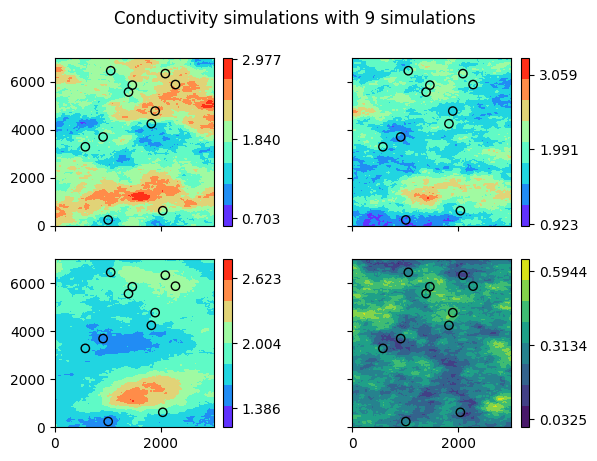

<Figure size 640x480 with 0 Axes>

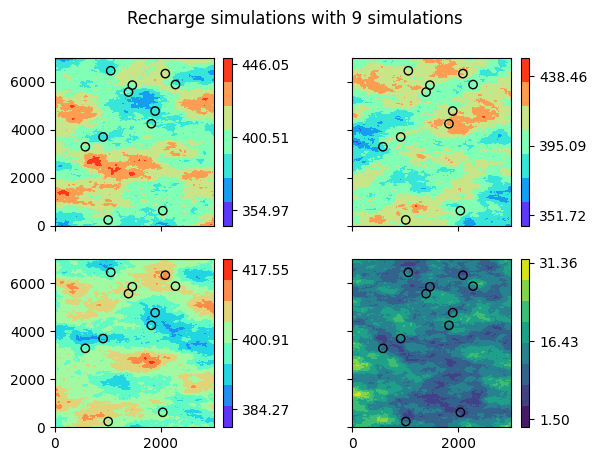

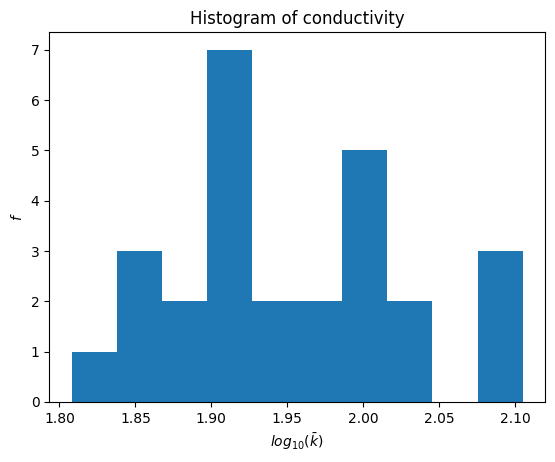

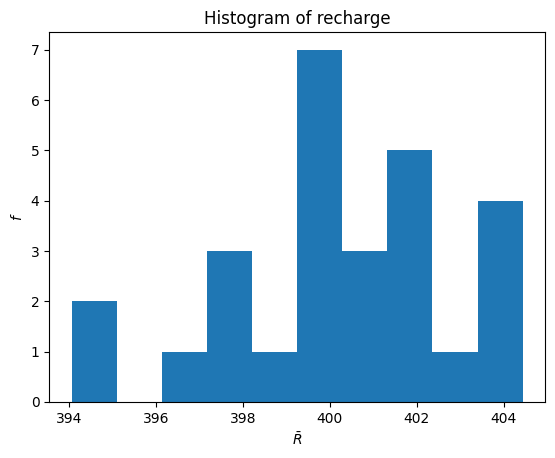

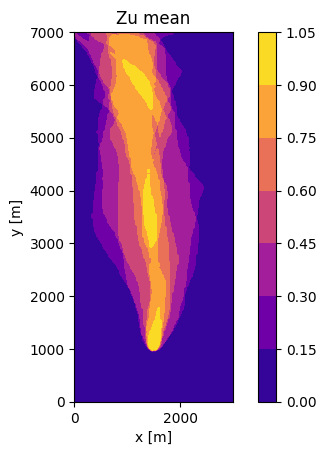

Calcul des coefficients pour la méthode standard:   0%|                                         | 0/10 [00:00<?, ?it/s]

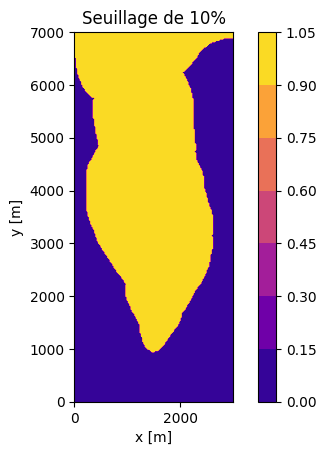

Calcul des coefficients pour la méthode standard:  10%|███▎                             | 1/10 [00:06<01:01,  6.83s/it]

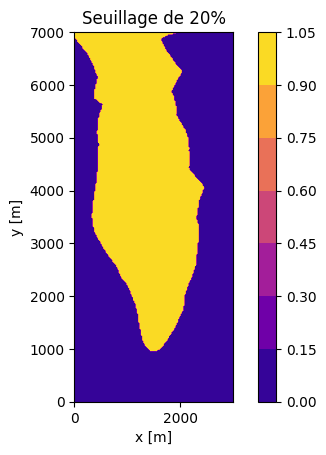

Calcul des coefficients pour la méthode standard:  20%|██████▌                          | 2/10 [00:13<00:54,  6.83s/it]

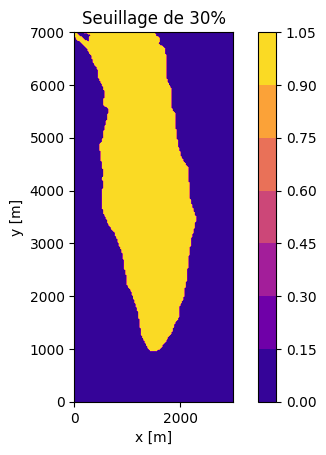

Calcul des coefficients pour la méthode standard:  30%|█████████▉                       | 3/10 [00:19<00:45,  6.49s/it]

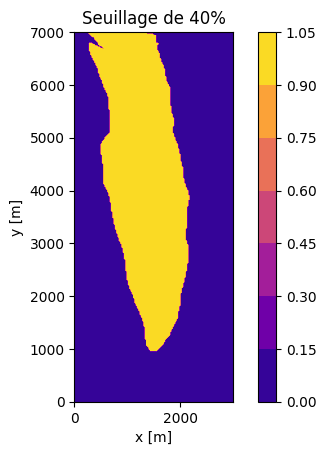

Calcul des coefficients pour la méthode standard:  40%|█████████████▏                   | 4/10 [00:25<00:37,  6.20s/it]

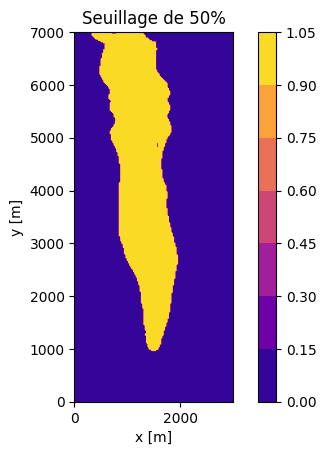

Calcul des coefficients pour la méthode standard:  50%|████████████████▌                | 5/10 [00:32<00:31,  6.31s/it]

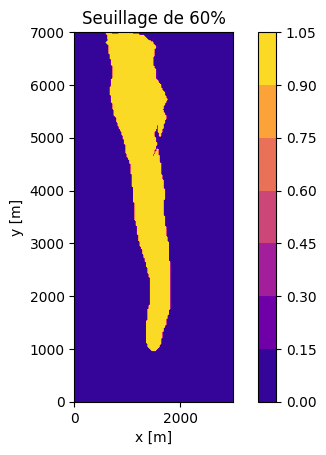

Calcul des coefficients pour la méthode standard:  60%|███████████████████▊             | 6/10 [00:38<00:25,  6.33s/it]

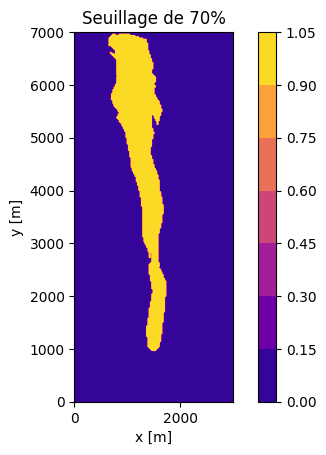

Calcul des coefficients pour la méthode standard:  70%|███████████████████████          | 7/10 [00:44<00:19,  6.36s/it]

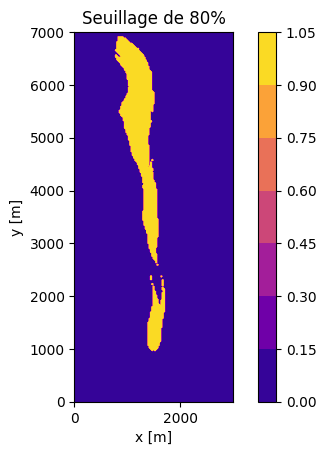

Calcul des coefficients pour la méthode standard:  80%|██████████████████████████▍      | 8/10 [00:51<00:12,  6.35s/it]

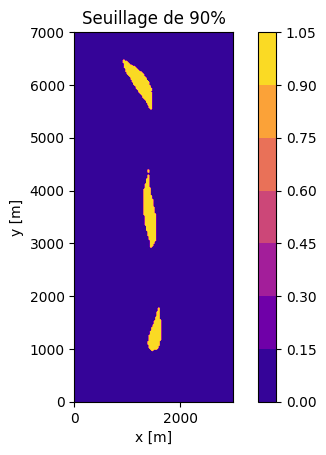

Calcul des coefficients pour la méthode standard:  90%|█████████████████████████████▋   | 9/10 [00:57<00:06,  6.36s/it]

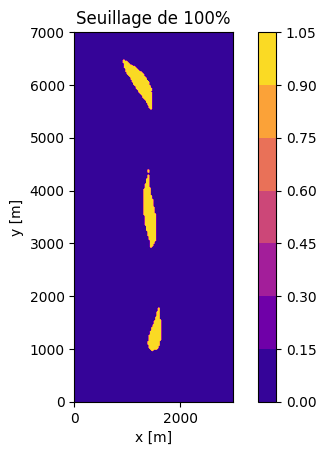

Calcul des coefficients pour la méthode standard: 100%|████████████████████████████████| 10/10 [01:03<00:00,  6.38s/it]


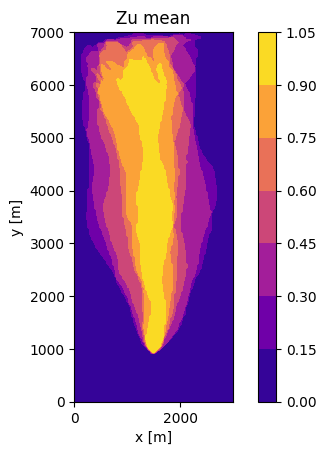

Calcul des coefficients pour la méthode meanlife:   0%|                                         | 0/10 [00:00<?, ?it/s]

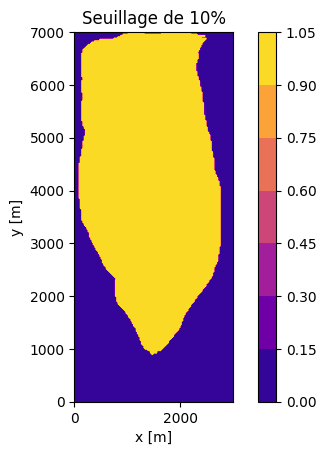

Calcul des coefficients pour la méthode meanlife:  10%|███▎                             | 1/10 [00:06<01:00,  6.69s/it]

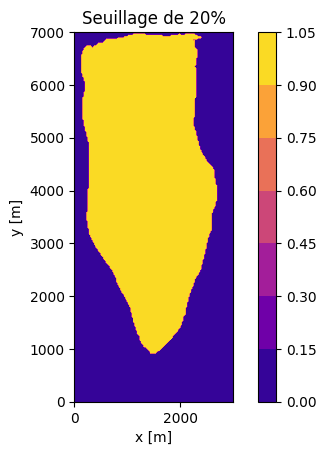

Calcul des coefficients pour la méthode meanlife:  20%|██████▌                          | 2/10 [00:13<00:53,  6.67s/it]

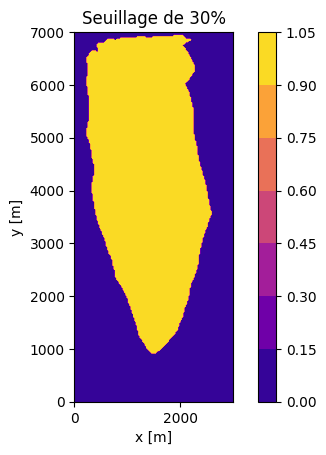

Calcul des coefficients pour la méthode meanlife:  30%|█████████▉                       | 3/10 [00:19<00:46,  6.58s/it]

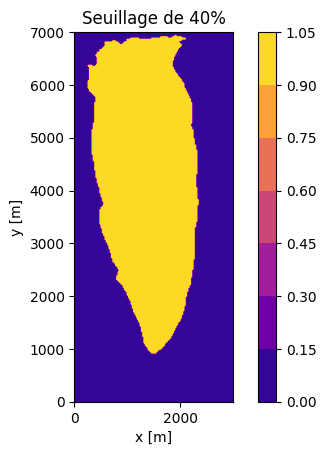

Calcul des coefficients pour la méthode meanlife:  40%|█████████████▏                   | 4/10 [00:26<00:38,  6.46s/it]

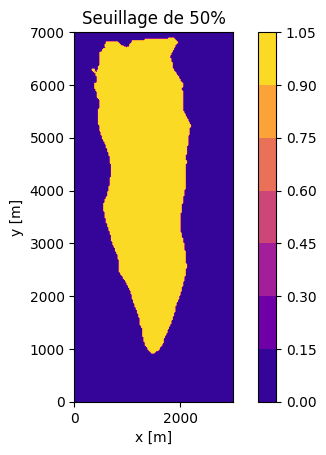

Calcul des coefficients pour la méthode meanlife:  50%|████████████████▌                | 5/10 [00:32<00:32,  6.44s/it]

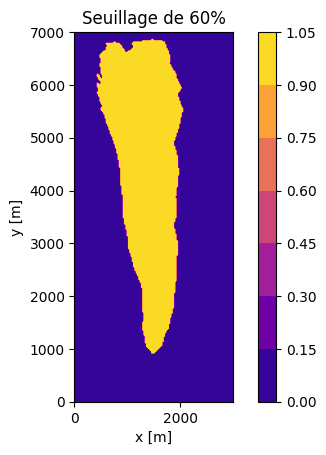

Calcul des coefficients pour la méthode meanlife:  60%|███████████████████▊             | 6/10 [00:38<00:25,  6.46s/it]

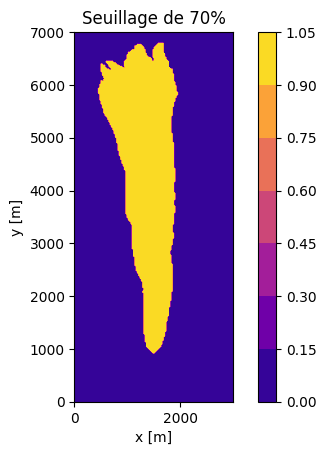

Calcul des coefficients pour la méthode meanlife:  70%|███████████████████████          | 7/10 [00:46<00:20,  6.69s/it]

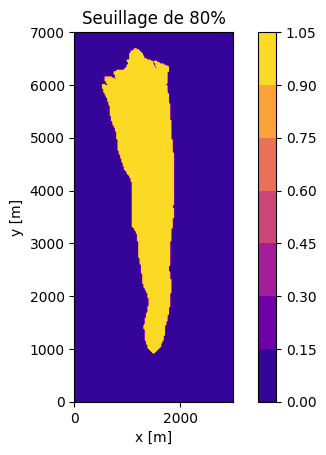

Calcul des coefficients pour la méthode meanlife:  80%|██████████████████████████▍      | 8/10 [00:53<00:13,  6.86s/it]

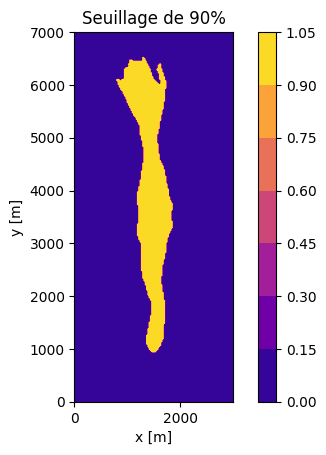

Calcul des coefficients pour la méthode meanlife:  90%|█████████████████████████████▋   | 9/10 [00:59<00:06,  6.70s/it]

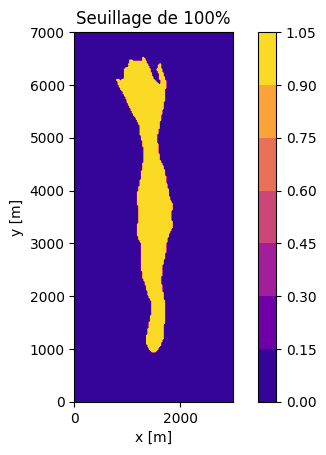

Calcul des coefficients pour la méthode meanlife: 100%|████████████████████████████████| 10/10 [01:07<00:00,  6.70s/it]


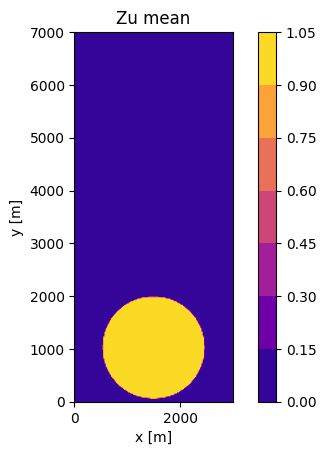

Calcul des coefficients pour la méthode cfr:   0%|                                              | 0/10 [00:00<?, ?it/s]

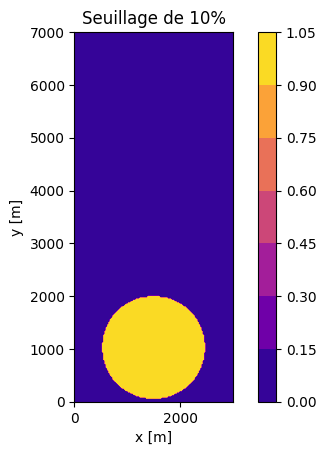

Calcul des coefficients pour la méthode cfr:  10%|███▊                                  | 1/10 [00:05<00:53,  5.98s/it]

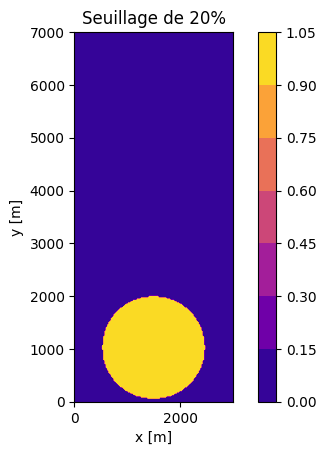

Calcul des coefficients pour la méthode cfr:  20%|███████▌                              | 2/10 [00:12<00:48,  6.07s/it]

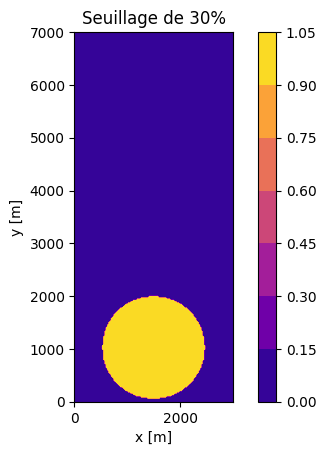

Calcul des coefficients pour la méthode cfr:  30%|███████████▍                          | 3/10 [00:18<00:43,  6.17s/it]

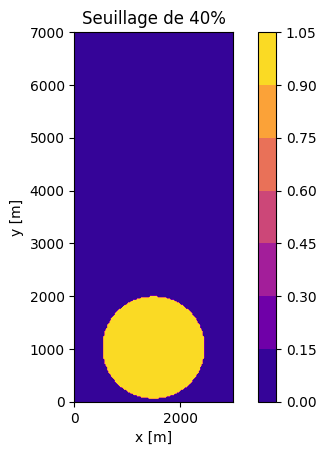

Calcul des coefficients pour la méthode cfr:  40%|███████████████▏                      | 4/10 [00:24<00:37,  6.19s/it]

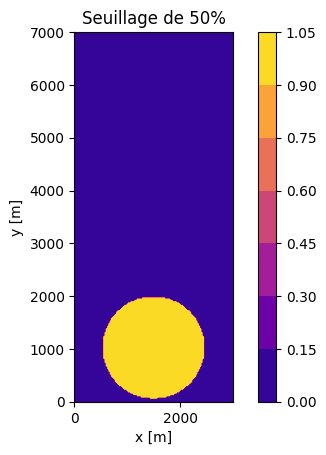

Calcul des coefficients pour la méthode cfr:  50%|███████████████████                   | 5/10 [00:30<00:30,  6.04s/it]

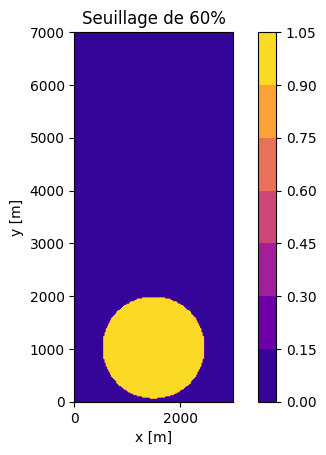

Calcul des coefficients pour la méthode cfr:  60%|██████████████████████▊               | 6/10 [00:36<00:24,  6.08s/it]

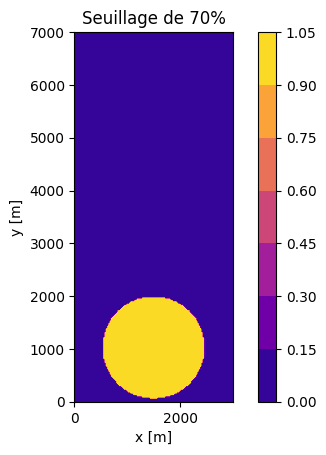

Calcul des coefficients pour la méthode cfr:  70%|██████████████████████████▌           | 7/10 [00:42<00:18,  6.12s/it]

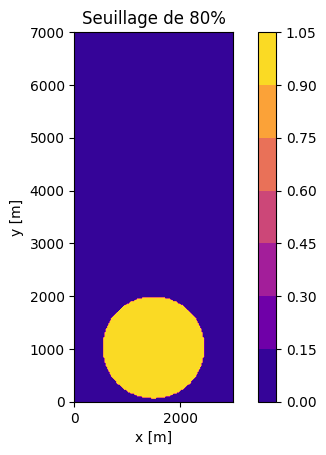

Calcul des coefficients pour la méthode cfr:  80%|██████████████████████████████▍       | 8/10 [00:48<00:12,  6.13s/it]

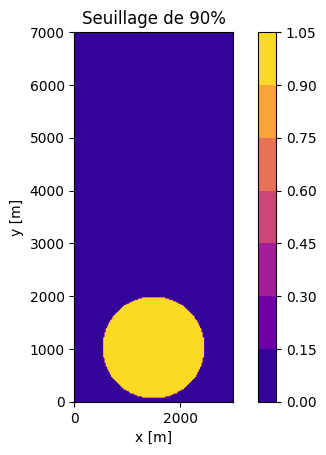

Calcul des coefficients pour la méthode cfr:  90%|██████████████████████████████████▏   | 9/10 [00:55<00:06,  6.14s/it]

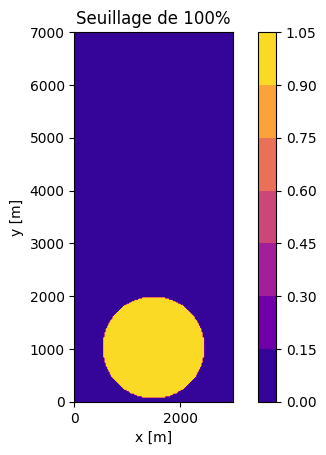

Calcul des coefficients pour la méthode cfr: 100%|█████████████████████████████████████| 10/10 [01:01<00:00,  6.13s/it]


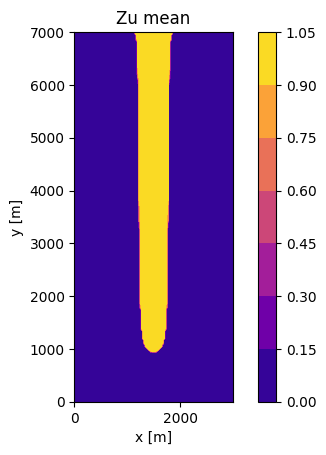

Calcul des coefficients pour la méthode lerner:   0%|                                           | 0/10 [00:00<?, ?it/s]

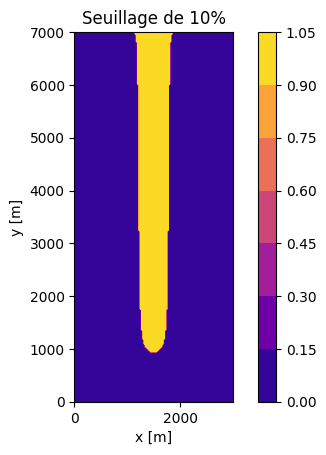

Calcul des coefficients pour la méthode lerner:  10%|███▌                               | 1/10 [00:05<00:53,  5.91s/it]

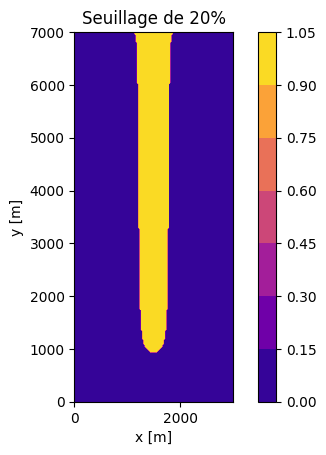

Calcul des coefficients pour la méthode lerner:  20%|███████                            | 2/10 [00:12<00:49,  6.19s/it]

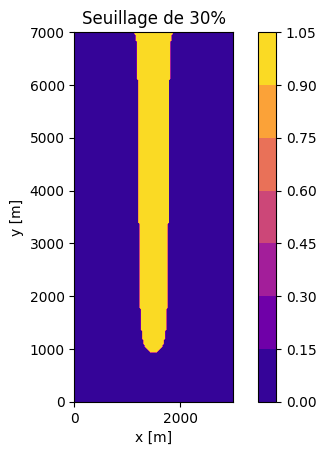

Calcul des coefficients pour la méthode lerner:  30%|██████████▌                        | 3/10 [00:18<00:42,  6.10s/it]

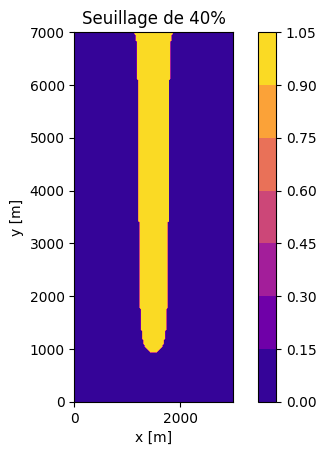

Calcul des coefficients pour la méthode lerner:  40%|██████████████                     | 4/10 [00:24<00:36,  6.12s/it]

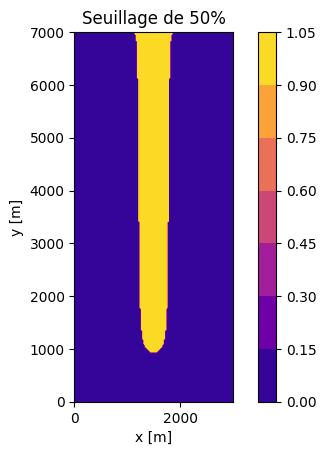

Calcul des coefficients pour la méthode lerner:  50%|█████████████████▌                 | 5/10 [00:30<00:30,  6.16s/it]

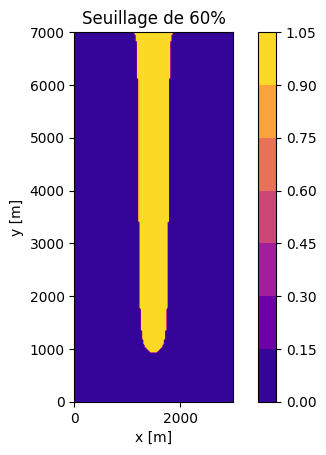

Calcul des coefficients pour la méthode lerner:  60%|█████████████████████              | 6/10 [00:36<00:24,  6.19s/it]

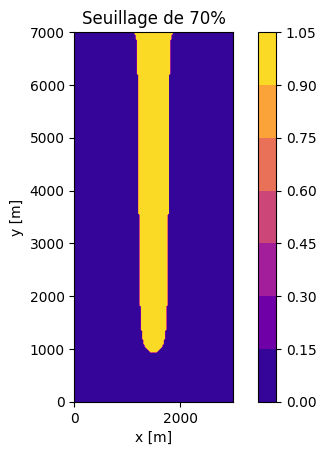

Calcul des coefficients pour la méthode lerner:  70%|████████████████████████▌          | 7/10 [00:43<00:18,  6.18s/it]

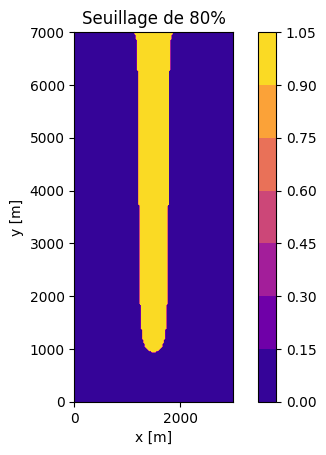

Calcul des coefficients pour la méthode lerner:  80%|████████████████████████████       | 8/10 [00:49<00:12,  6.18s/it]

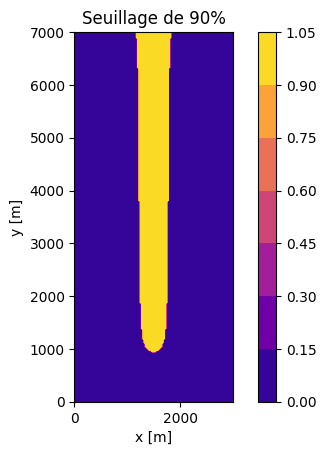

Calcul des coefficients pour la méthode lerner:  90%|███████████████████████████████▌   | 9/10 [00:56<00:06,  6.48s/it]

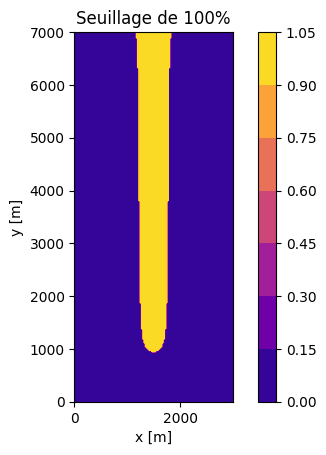

Calcul des coefficients pour la méthode lerner: 100%|██████████████████████████████████| 10/10 [01:02<00:00,  6.24s/it]


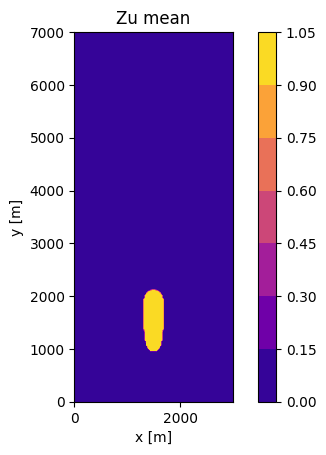

Calcul des coefficients pour la méthode bear-jacobs:   0%|                                      | 0/10 [00:00<?, ?it/s]

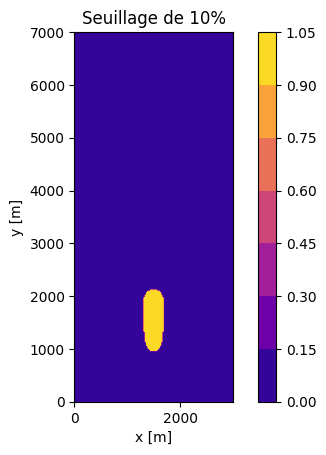

Calcul des coefficients pour la méthode bear-jacobs:  10%|███                           | 1/10 [00:05<00:53,  5.97s/it]

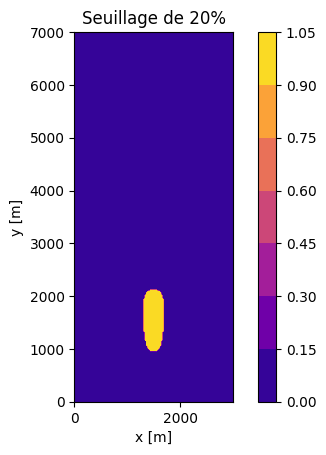

Calcul des coefficients pour la méthode bear-jacobs:  20%|██████                        | 2/10 [00:12<00:49,  6.13s/it]

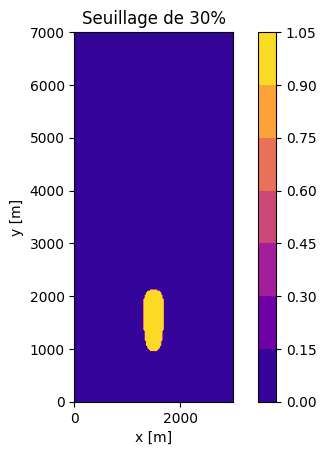

Calcul des coefficients pour la méthode bear-jacobs:  30%|█████████                     | 3/10 [00:18<00:43,  6.17s/it]

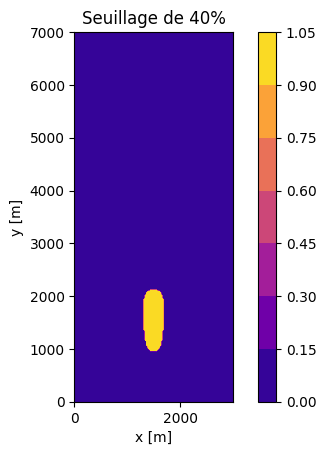

Calcul des coefficients pour la méthode bear-jacobs:  40%|████████████                  | 4/10 [00:24<00:36,  6.16s/it]

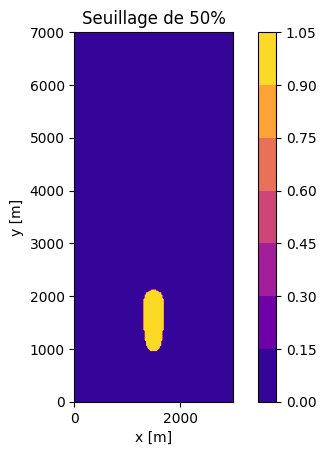

Calcul des coefficients pour la méthode bear-jacobs:  50%|███████████████               | 5/10 [00:31<00:32,  6.41s/it]

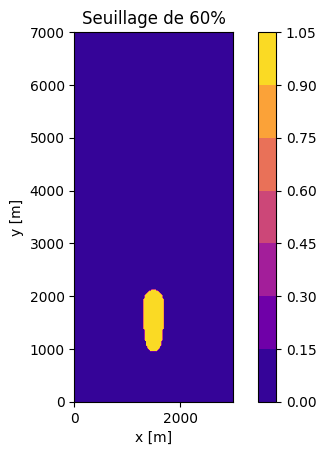

Calcul des coefficients pour la méthode bear-jacobs:  60%|██████████████████            | 6/10 [00:37<00:25,  6.31s/it]

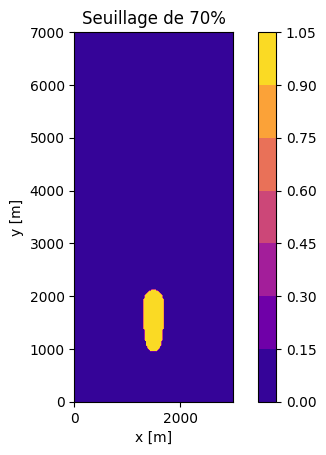

Calcul des coefficients pour la méthode bear-jacobs:  70%|█████████████████████         | 7/10 [00:44<00:19,  6.45s/it]

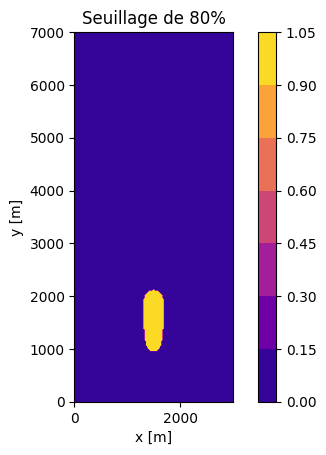

Calcul des coefficients pour la méthode bear-jacobs:  80%|████████████████████████      | 8/10 [00:51<00:13,  6.57s/it]

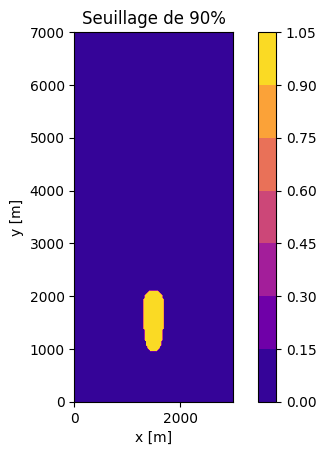

Calcul des coefficients pour la méthode bear-jacobs:  90%|███████████████████████████   | 9/10 [00:58<00:06,  6.86s/it]

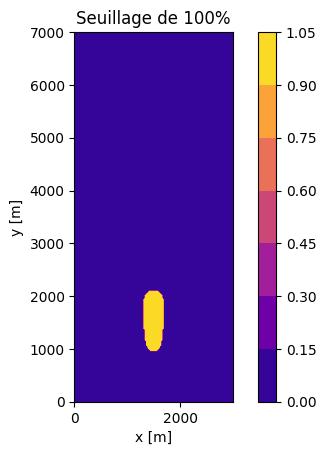

Calcul des coefficients pour la méthode bear-jacobs: 100%|█████████████████████████████| 10/10 [01:05<00:00,  6.52s/it]


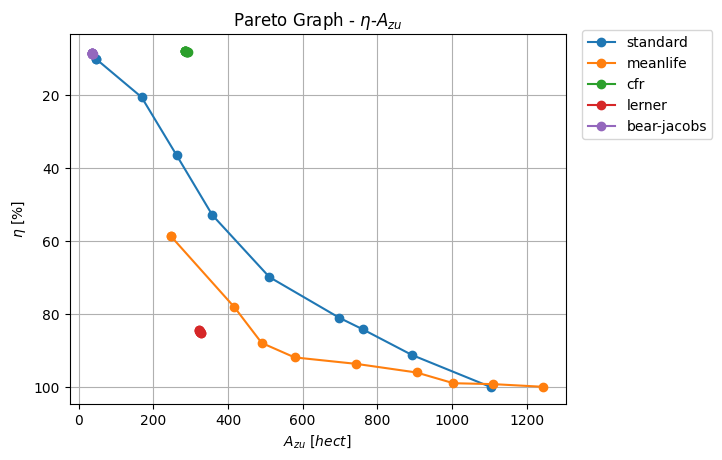

In [3]:
data.stochastic_study(10, ['standard', 'meanlife', 'cfr', 'lerner', 'bear-jacobs'], 10)

#### Exemple avec 30 données conditionnantes, pour toutes les méthodes, et pour 30 simulations de zone Zu

calcul des Zu: 100%|███████████████████████████████████████████████████████████████████| 30/30 [13:11<00:00, 26.39s/it]


<Figure size 640x480 with 0 Axes>

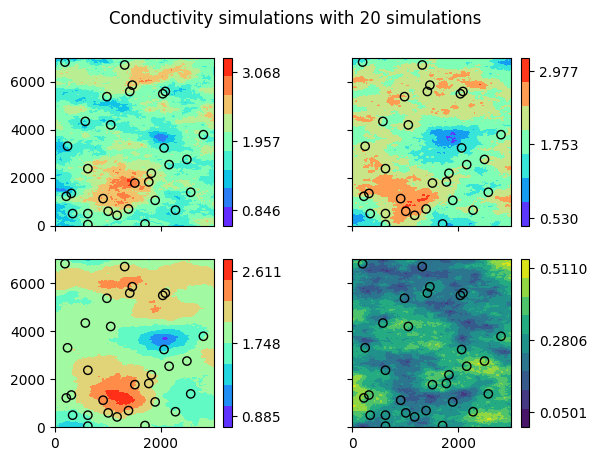

<Figure size 640x480 with 0 Axes>

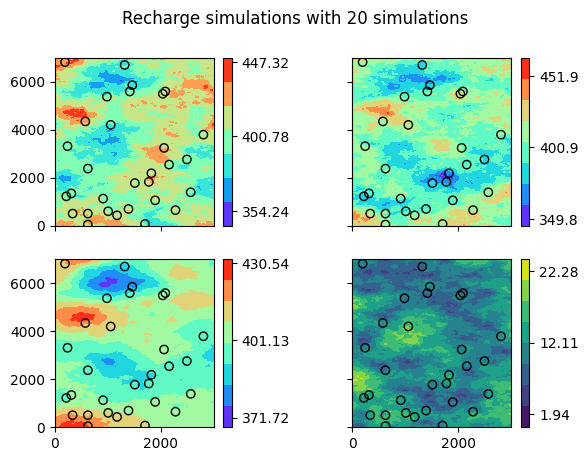

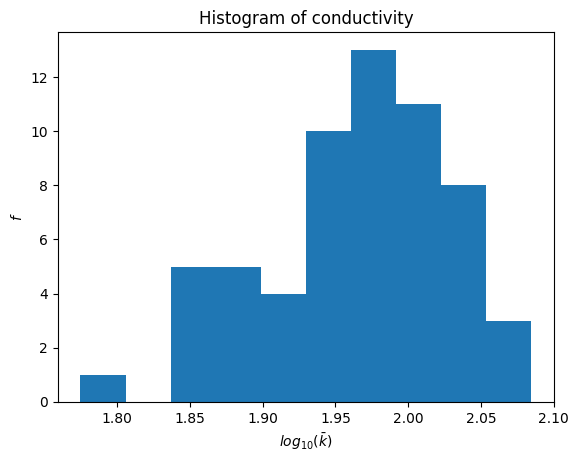

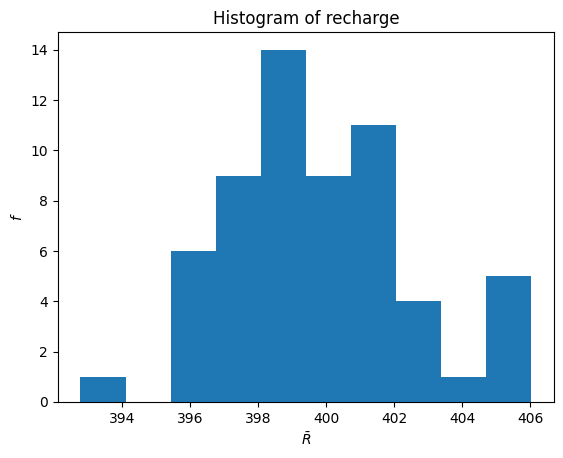

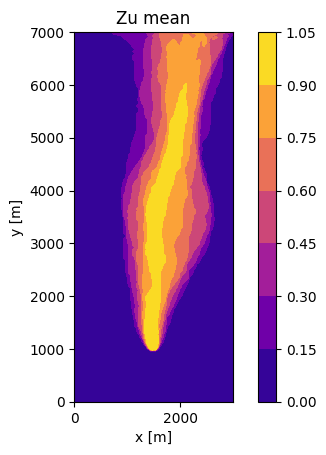

Calcul des coefficients pour la méthode standard:   0%|                                         | 0/10 [00:00<?, ?it/s]

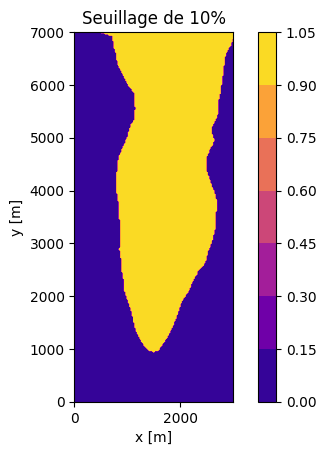

Calcul des coefficients pour la méthode standard:  10%|███▎                             | 1/10 [00:07<01:04,  7.22s/it]

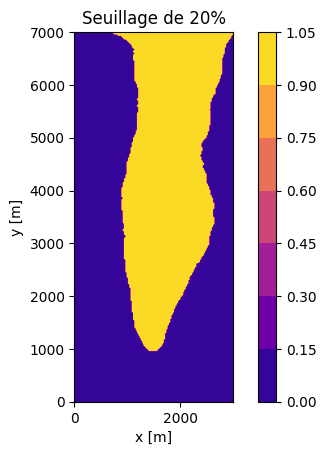

Calcul des coefficients pour la méthode standard:  20%|██████▌                          | 2/10 [00:14<00:58,  7.34s/it]

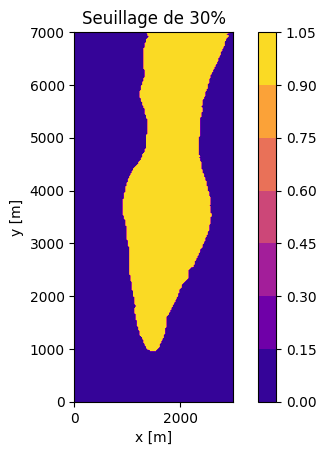

Calcul des coefficients pour la méthode standard:  30%|█████████▉                       | 3/10 [00:21<00:51,  7.29s/it]

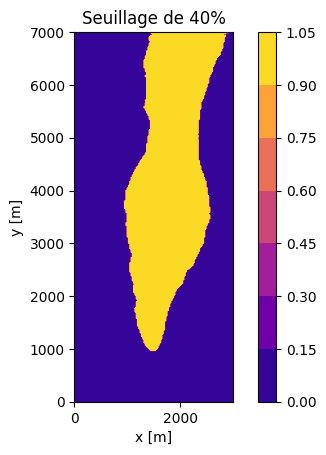

Calcul des coefficients pour la méthode standard:  40%|█████████████▏                   | 4/10 [00:31<00:48,  8.13s/it]

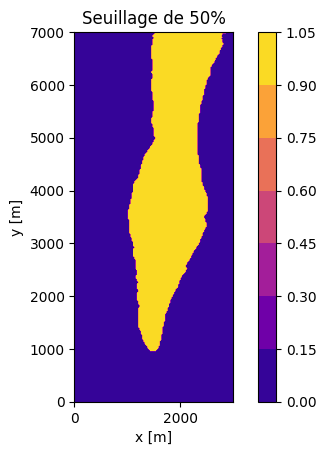

Calcul des coefficients pour la méthode standard:  50%|████████████████▌                | 5/10 [00:38<00:38,  7.65s/it]

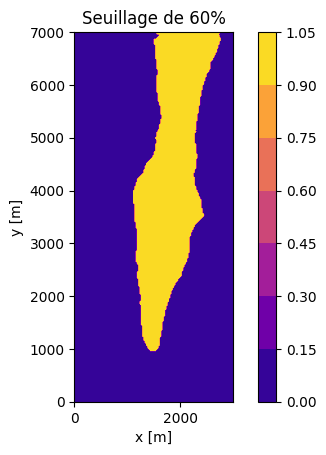

Calcul des coefficients pour la méthode standard:  60%|███████████████████▊             | 6/10 [00:43<00:28,  7.00s/it]

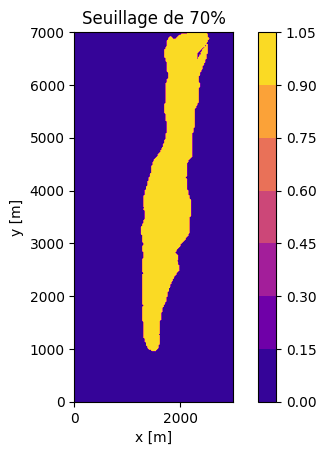

Calcul des coefficients pour la méthode standard:  70%|███████████████████████          | 7/10 [00:50<00:20,  6.75s/it]

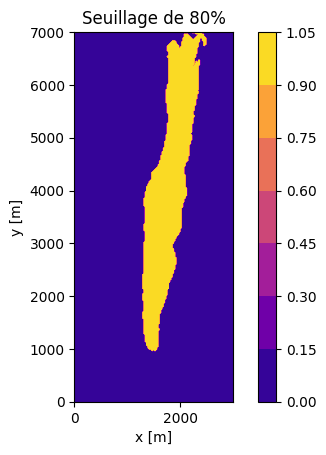

Calcul des coefficients pour la méthode standard:  80%|██████████████████████████▍      | 8/10 [00:55<00:12,  6.42s/it]

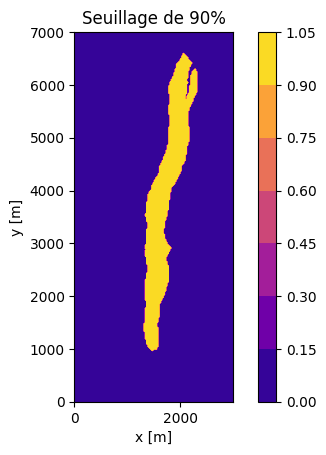

Calcul des coefficients pour la méthode standard:  90%|█████████████████████████████▋   | 9/10 [01:01<00:06,  6.34s/it]

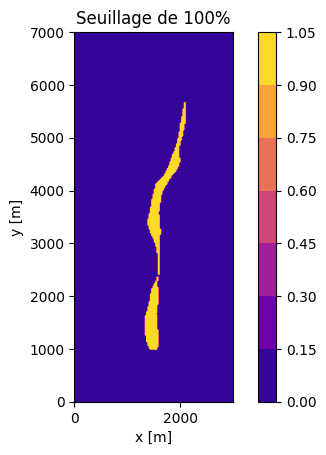

Calcul des coefficients pour la méthode standard: 100%|████████████████████████████████| 10/10 [01:08<00:00,  6.82s/it]


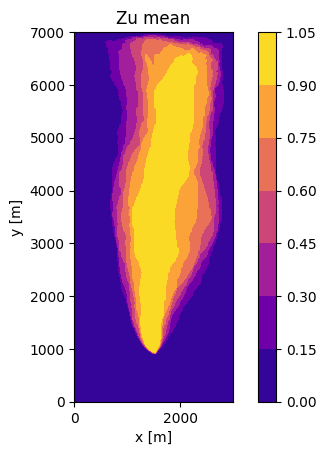

Calcul des coefficients pour la méthode meanlife:   0%|                                         | 0/10 [00:00<?, ?it/s]

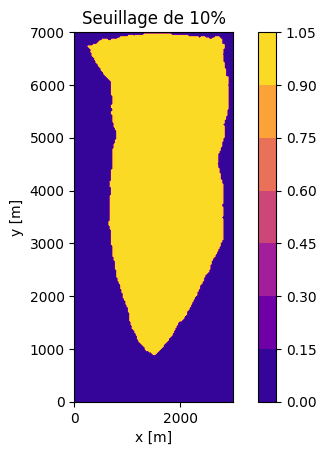

Calcul des coefficients pour la méthode meanlife:  10%|███▎                             | 1/10 [00:06<01:00,  6.68s/it]

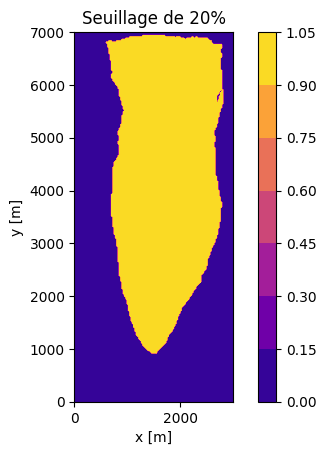

Calcul des coefficients pour la méthode meanlife:  20%|██████▌                          | 2/10 [00:12<00:50,  6.33s/it]

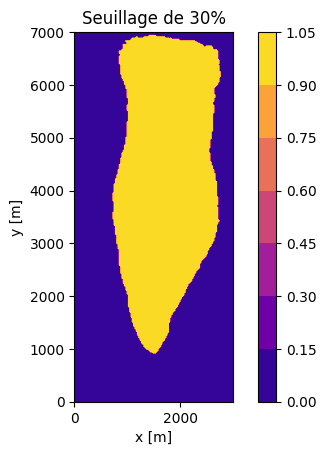

Calcul des coefficients pour la méthode meanlife:  30%|█████████▉                       | 3/10 [00:19<00:45,  6.54s/it]

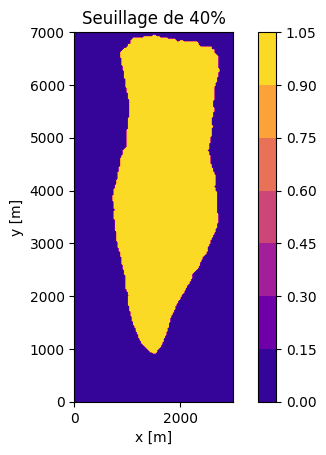

Calcul des coefficients pour la méthode meanlife:  40%|█████████████▏                   | 4/10 [00:26<00:40,  6.77s/it]

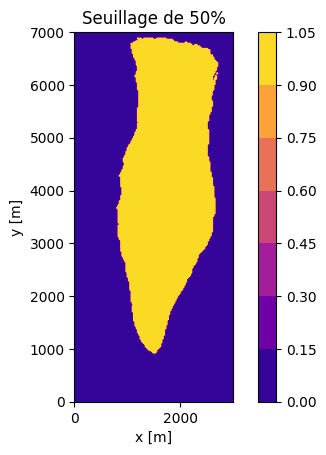

Calcul des coefficients pour la méthode meanlife:  50%|████████████████▌                | 5/10 [00:33<00:34,  6.82s/it]

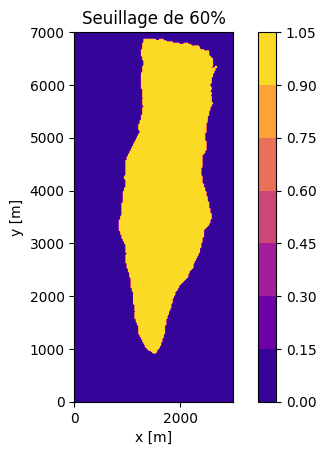

Calcul des coefficients pour la méthode meanlife:  60%|███████████████████▊             | 6/10 [00:39<00:26,  6.61s/it]

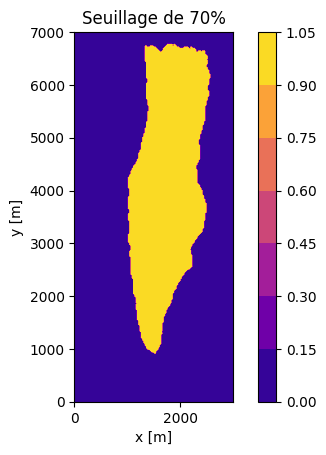

Calcul des coefficients pour la méthode meanlife:  70%|███████████████████████          | 7/10 [00:46<00:19,  6.60s/it]

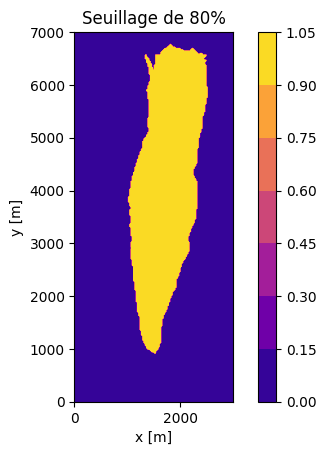

Calcul des coefficients pour la méthode meanlife:  80%|██████████████████████████▍      | 8/10 [00:53<00:13,  6.77s/it]

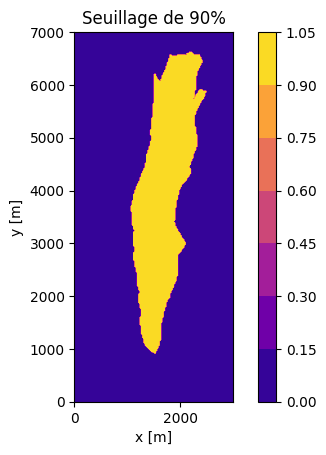

Calcul des coefficients pour la méthode meanlife:  90%|█████████████████████████████▋   | 9/10 [00:59<00:06,  6.68s/it]

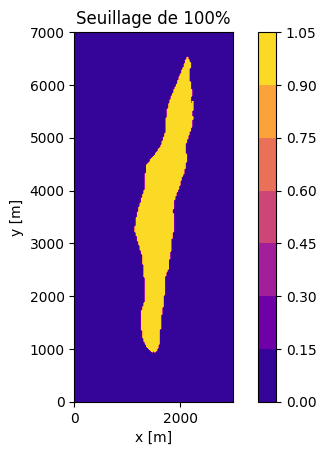

Calcul des coefficients pour la méthode meanlife: 100%|████████████████████████████████| 10/10 [01:07<00:00,  6.73s/it]


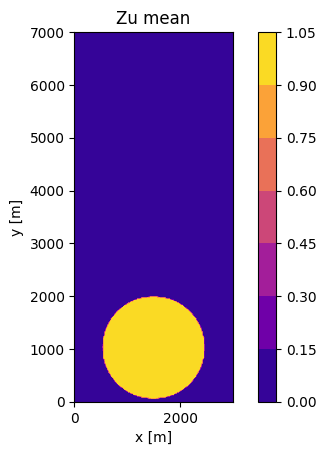

Calcul des coefficients pour la méthode cfr:   0%|                                              | 0/10 [00:00<?, ?it/s]

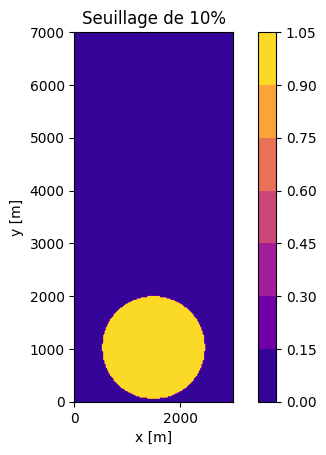

Calcul des coefficients pour la méthode cfr:  10%|███▊                                  | 1/10 [00:07<01:06,  7.39s/it]

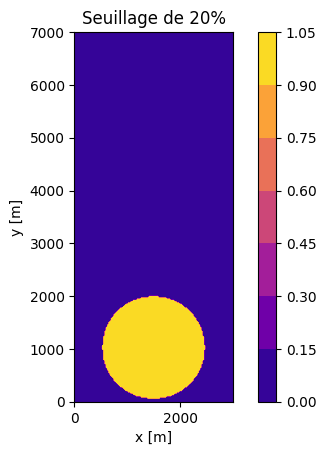

Calcul des coefficients pour la méthode cfr:  20%|███████▌                              | 2/10 [00:14<00:57,  7.19s/it]

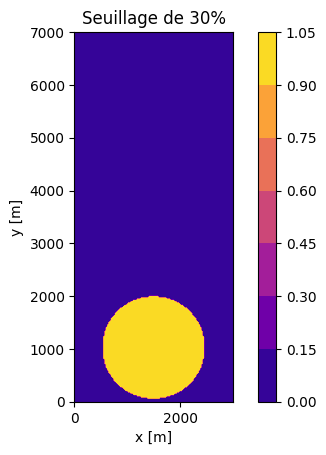

Calcul des coefficients pour la méthode cfr:  30%|███████████▍                          | 3/10 [00:21<00:50,  7.26s/it]

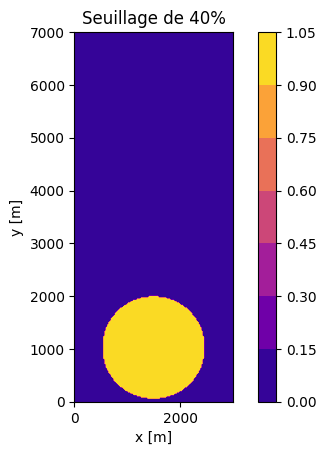

Calcul des coefficients pour la méthode cfr:  40%|███████████████▏                      | 4/10 [00:29<00:43,  7.32s/it]

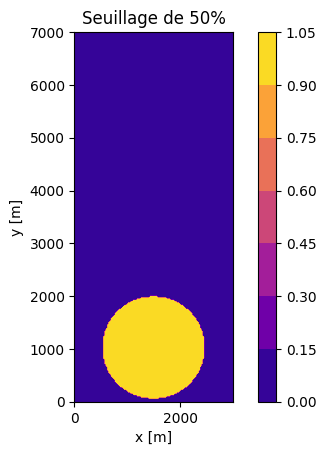

Calcul des coefficients pour la méthode cfr:  50%|███████████████████                   | 5/10 [00:35<00:35,  7.12s/it]

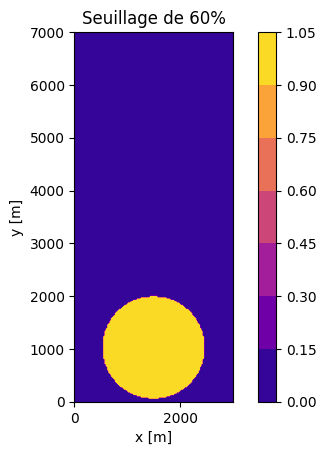

Calcul des coefficients pour la méthode cfr:  60%|██████████████████████▊               | 6/10 [00:41<00:26,  6.73s/it]

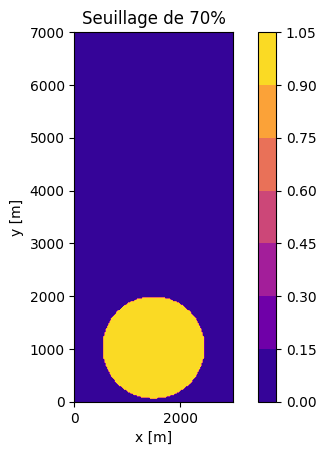

Calcul des coefficients pour la méthode cfr:  70%|██████████████████████████▌           | 7/10 [00:49<00:20,  6.98s/it]

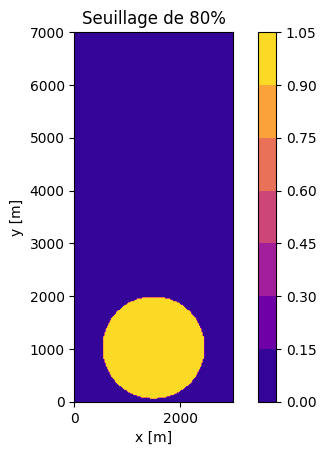

Calcul des coefficients pour la méthode cfr:  80%|██████████████████████████████▍       | 8/10 [00:58<00:15,  7.59s/it]

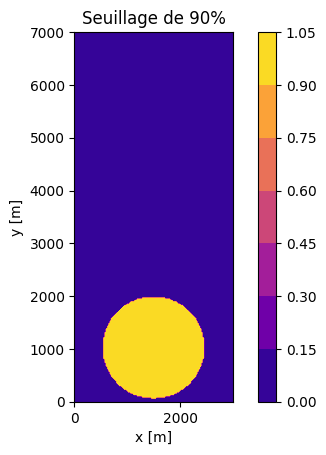

Calcul des coefficients pour la méthode cfr:  90%|██████████████████████████████████▏   | 9/10 [01:07<00:08,  8.20s/it]

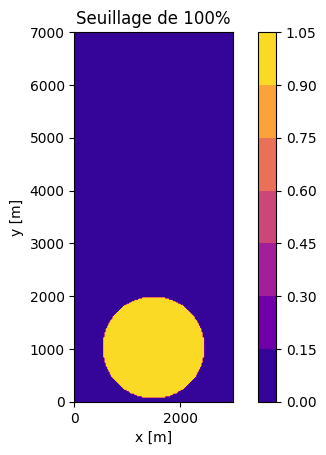

Calcul des coefficients pour la méthode cfr: 100%|█████████████████████████████████████| 10/10 [01:15<00:00,  7.59s/it]


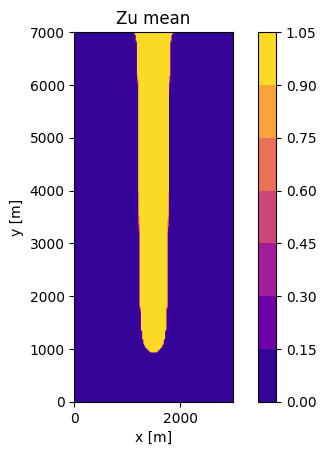

Calcul des coefficients pour la méthode lerner:   0%|                                           | 0/10 [00:00<?, ?it/s]

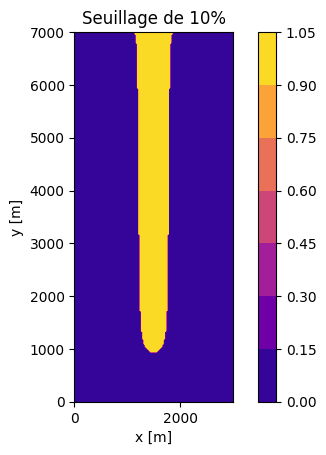

Calcul des coefficients pour la méthode lerner:  10%|███▌                               | 1/10 [00:08<01:16,  8.47s/it]

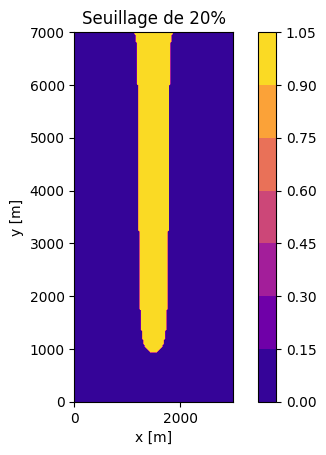

Calcul des coefficients pour la méthode lerner:  20%|███████                            | 2/10 [00:14<00:55,  6.98s/it]

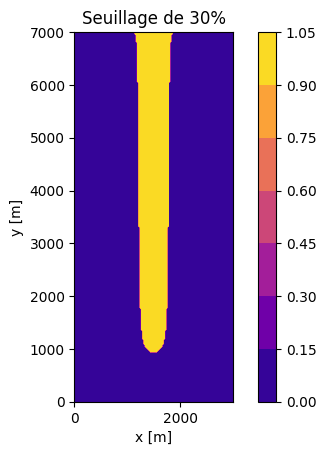

Calcul des coefficients pour la méthode lerner:  30%|██████████▌                        | 3/10 [00:20<00:46,  6.70s/it]

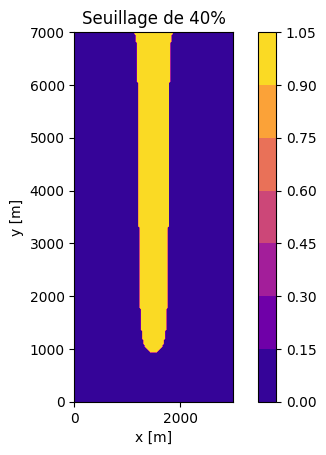

Calcul des coefficients pour la méthode lerner:  40%|██████████████                     | 4/10 [00:26<00:38,  6.46s/it]

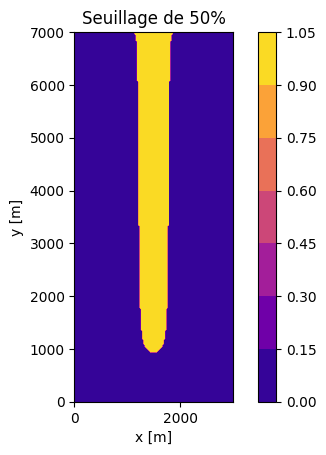

Calcul des coefficients pour la méthode lerner:  50%|█████████████████▌                 | 5/10 [00:33<00:31,  6.37s/it]

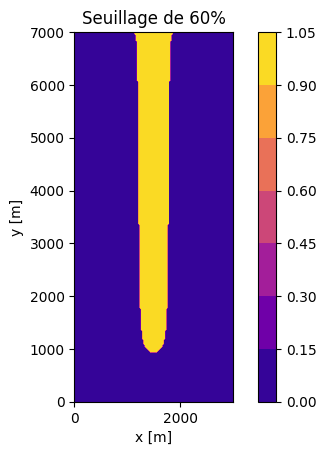

Calcul des coefficients pour la méthode lerner:  60%|█████████████████████              | 6/10 [00:39<00:25,  6.32s/it]

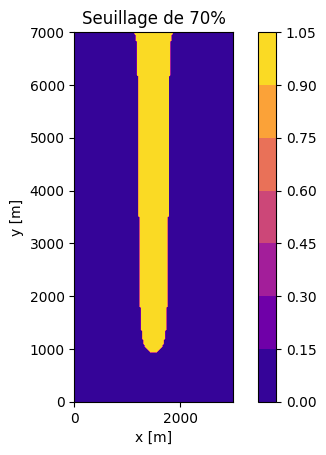

Calcul des coefficients pour la méthode lerner:  70%|████████████████████████▌          | 7/10 [00:45<00:18,  6.12s/it]

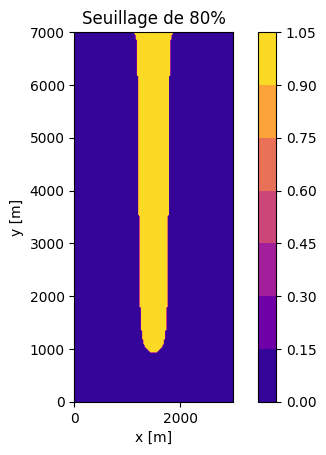

Calcul des coefficients pour la méthode lerner:  80%|████████████████████████████       | 8/10 [00:50<00:11,  6.00s/it]

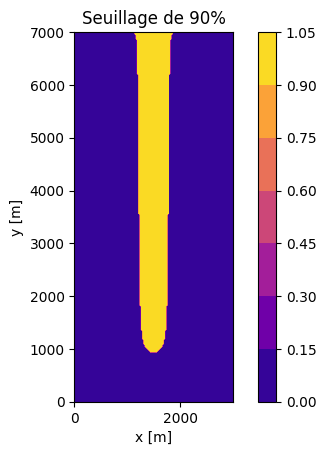

Calcul des coefficients pour la méthode lerner:  90%|███████████████████████████████▌   | 9/10 [00:57<00:06,  6.08s/it]

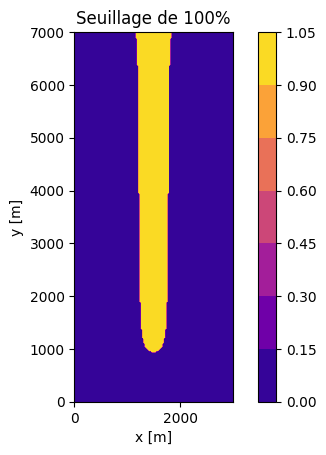

Calcul des coefficients pour la méthode lerner: 100%|██████████████████████████████████| 10/10 [01:02<00:00,  6.28s/it]


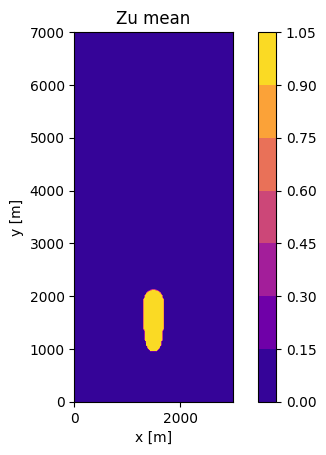

Calcul des coefficients pour la méthode bear-jacobs:   0%|                                      | 0/10 [00:00<?, ?it/s]

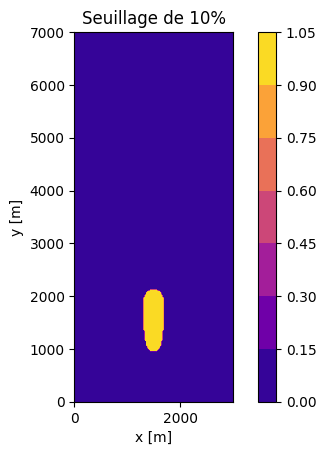

Calcul des coefficients pour la méthode bear-jacobs:  10%|███                           | 1/10 [00:06<00:58,  6.49s/it]

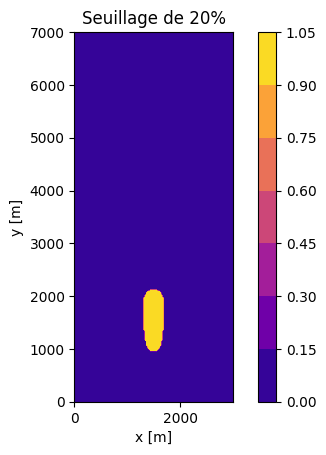

Calcul des coefficients pour la méthode bear-jacobs:  20%|██████                        | 2/10 [00:13<00:54,  6.79s/it]

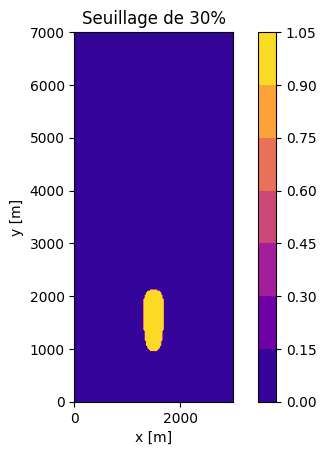

Calcul des coefficients pour la méthode bear-jacobs:  30%|█████████                     | 3/10 [00:19<00:45,  6.57s/it]

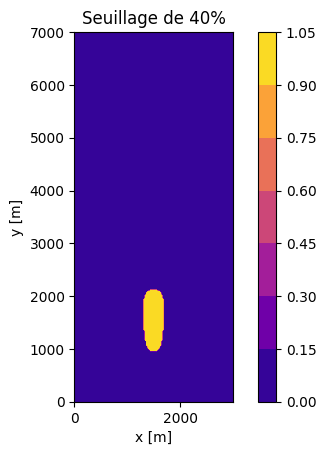

Calcul des coefficients pour la méthode bear-jacobs:  40%|████████████                  | 4/10 [00:25<00:37,  6.31s/it]

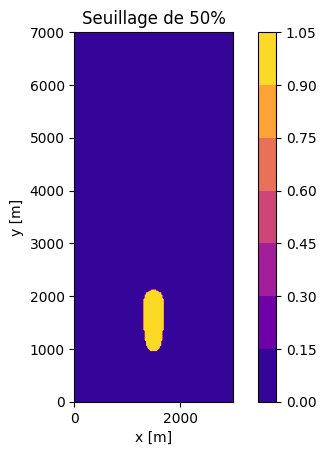

Calcul des coefficients pour la méthode bear-jacobs:  50%|███████████████               | 5/10 [00:32<00:31,  6.31s/it]

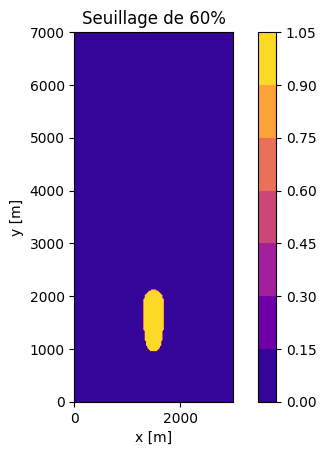

Calcul des coefficients pour la méthode bear-jacobs:  60%|██████████████████            | 6/10 [00:38<00:25,  6.49s/it]

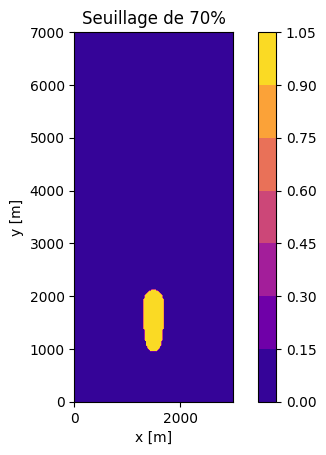

Calcul des coefficients pour la méthode bear-jacobs:  70%|█████████████████████         | 7/10 [00:45<00:19,  6.44s/it]

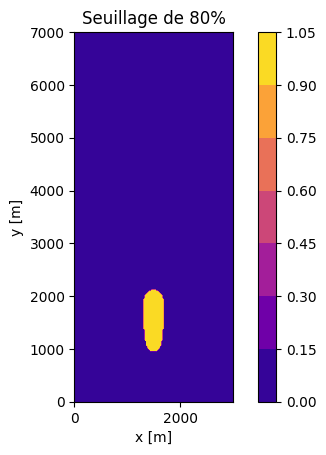

Calcul des coefficients pour la méthode bear-jacobs:  80%|████████████████████████      | 8/10 [00:52<00:13,  6.72s/it]

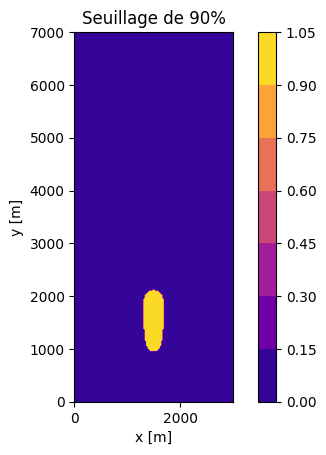

Calcul des coefficients pour la méthode bear-jacobs:  90%|███████████████████████████   | 9/10 [00:58<00:06,  6.56s/it]

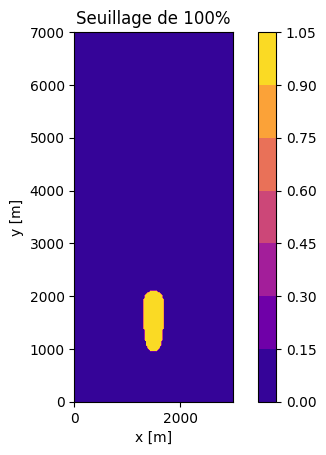

Calcul des coefficients pour la méthode bear-jacobs: 100%|█████████████████████████████| 10/10 [01:06<00:00,  6.63s/it]


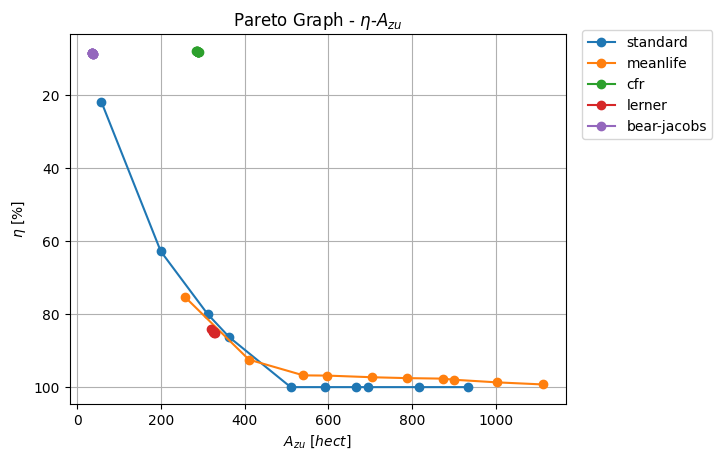

In [4]:
data.stochastic_study(30, ['standard', 'meanlife', 'cfr', 'lerner', 'bear-jacobs'], 30)